In [1]:
# importing all the required libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

In [2]:
# importing the file with the combined data of both the hospitals and splitting it into 2 parts

combined = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset.csv')

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [3]:
df_train = pd.read_csv('/content/data_part1.csv')
df_test = pd.read_csv('/content/data_part2.csv')

In [4]:
df_train.head(15)

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
5,5,5,62.0,100.0,NaN,124.0,85.0,61.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,6,0,17072
6,6,6,61.0,100.0,NaN,101.0,75.0,58.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,7,0,17072
7,7,7,68.0,100.0,35.78,142.0,93.5,78.0,16.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,8,0,17072
8,8,8,71.0,100.0,NaN,121.0,74.0,91.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,9,0,17072
9,9,9,69.0,100.0,NaN,120.0,79.0,98.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,10,0,17072


In [5]:
# let's list down all the different columns

df_train.columns

Index(['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP',
       'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2',
       'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID'],
      dtype='object')

In [6]:
# list of all the unique patients
# total number of patients present in the dataset

patients = list(df_test['Patient_ID'].unique())
len(patients)

20000

In [7]:
# Function to draw correlation heat map

def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [8]:
# Percentage of null values present in all the parameters

null_values = df_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

EtCO2               100.000000
TroponinI            99.877881
Bilirubin_direct     99.850420
Fibrinogen           99.236917
Bilirubin_total      98.773372
Alkalinephos         98.540650
AST                  98.504205
Lactate              96.565112
PTT                  95.152459
SaO2                 95.044387
Calcium              95.024392
Phosphate            94.951247
Platelets            93.482913
Creatinine           93.357884
WBC                  92.489639
Magnesium            92.219712
HCO3                 91.949406
BUN                  91.840702
Chloride             91.676063
PaCO2                91.231753
Hgb                  91.164303
BaseExcess           89.574863
Potassium            89.137640
pH                   88.532868
Hct                  88.223711
Glucose              87.768392
FiO2                 85.807027
Temp                 66.224255
Unit1                48.868346
Unit2                48.868346
DBP                  48.125763
SBP                  15.211177
O2Sat   

In [9]:
columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

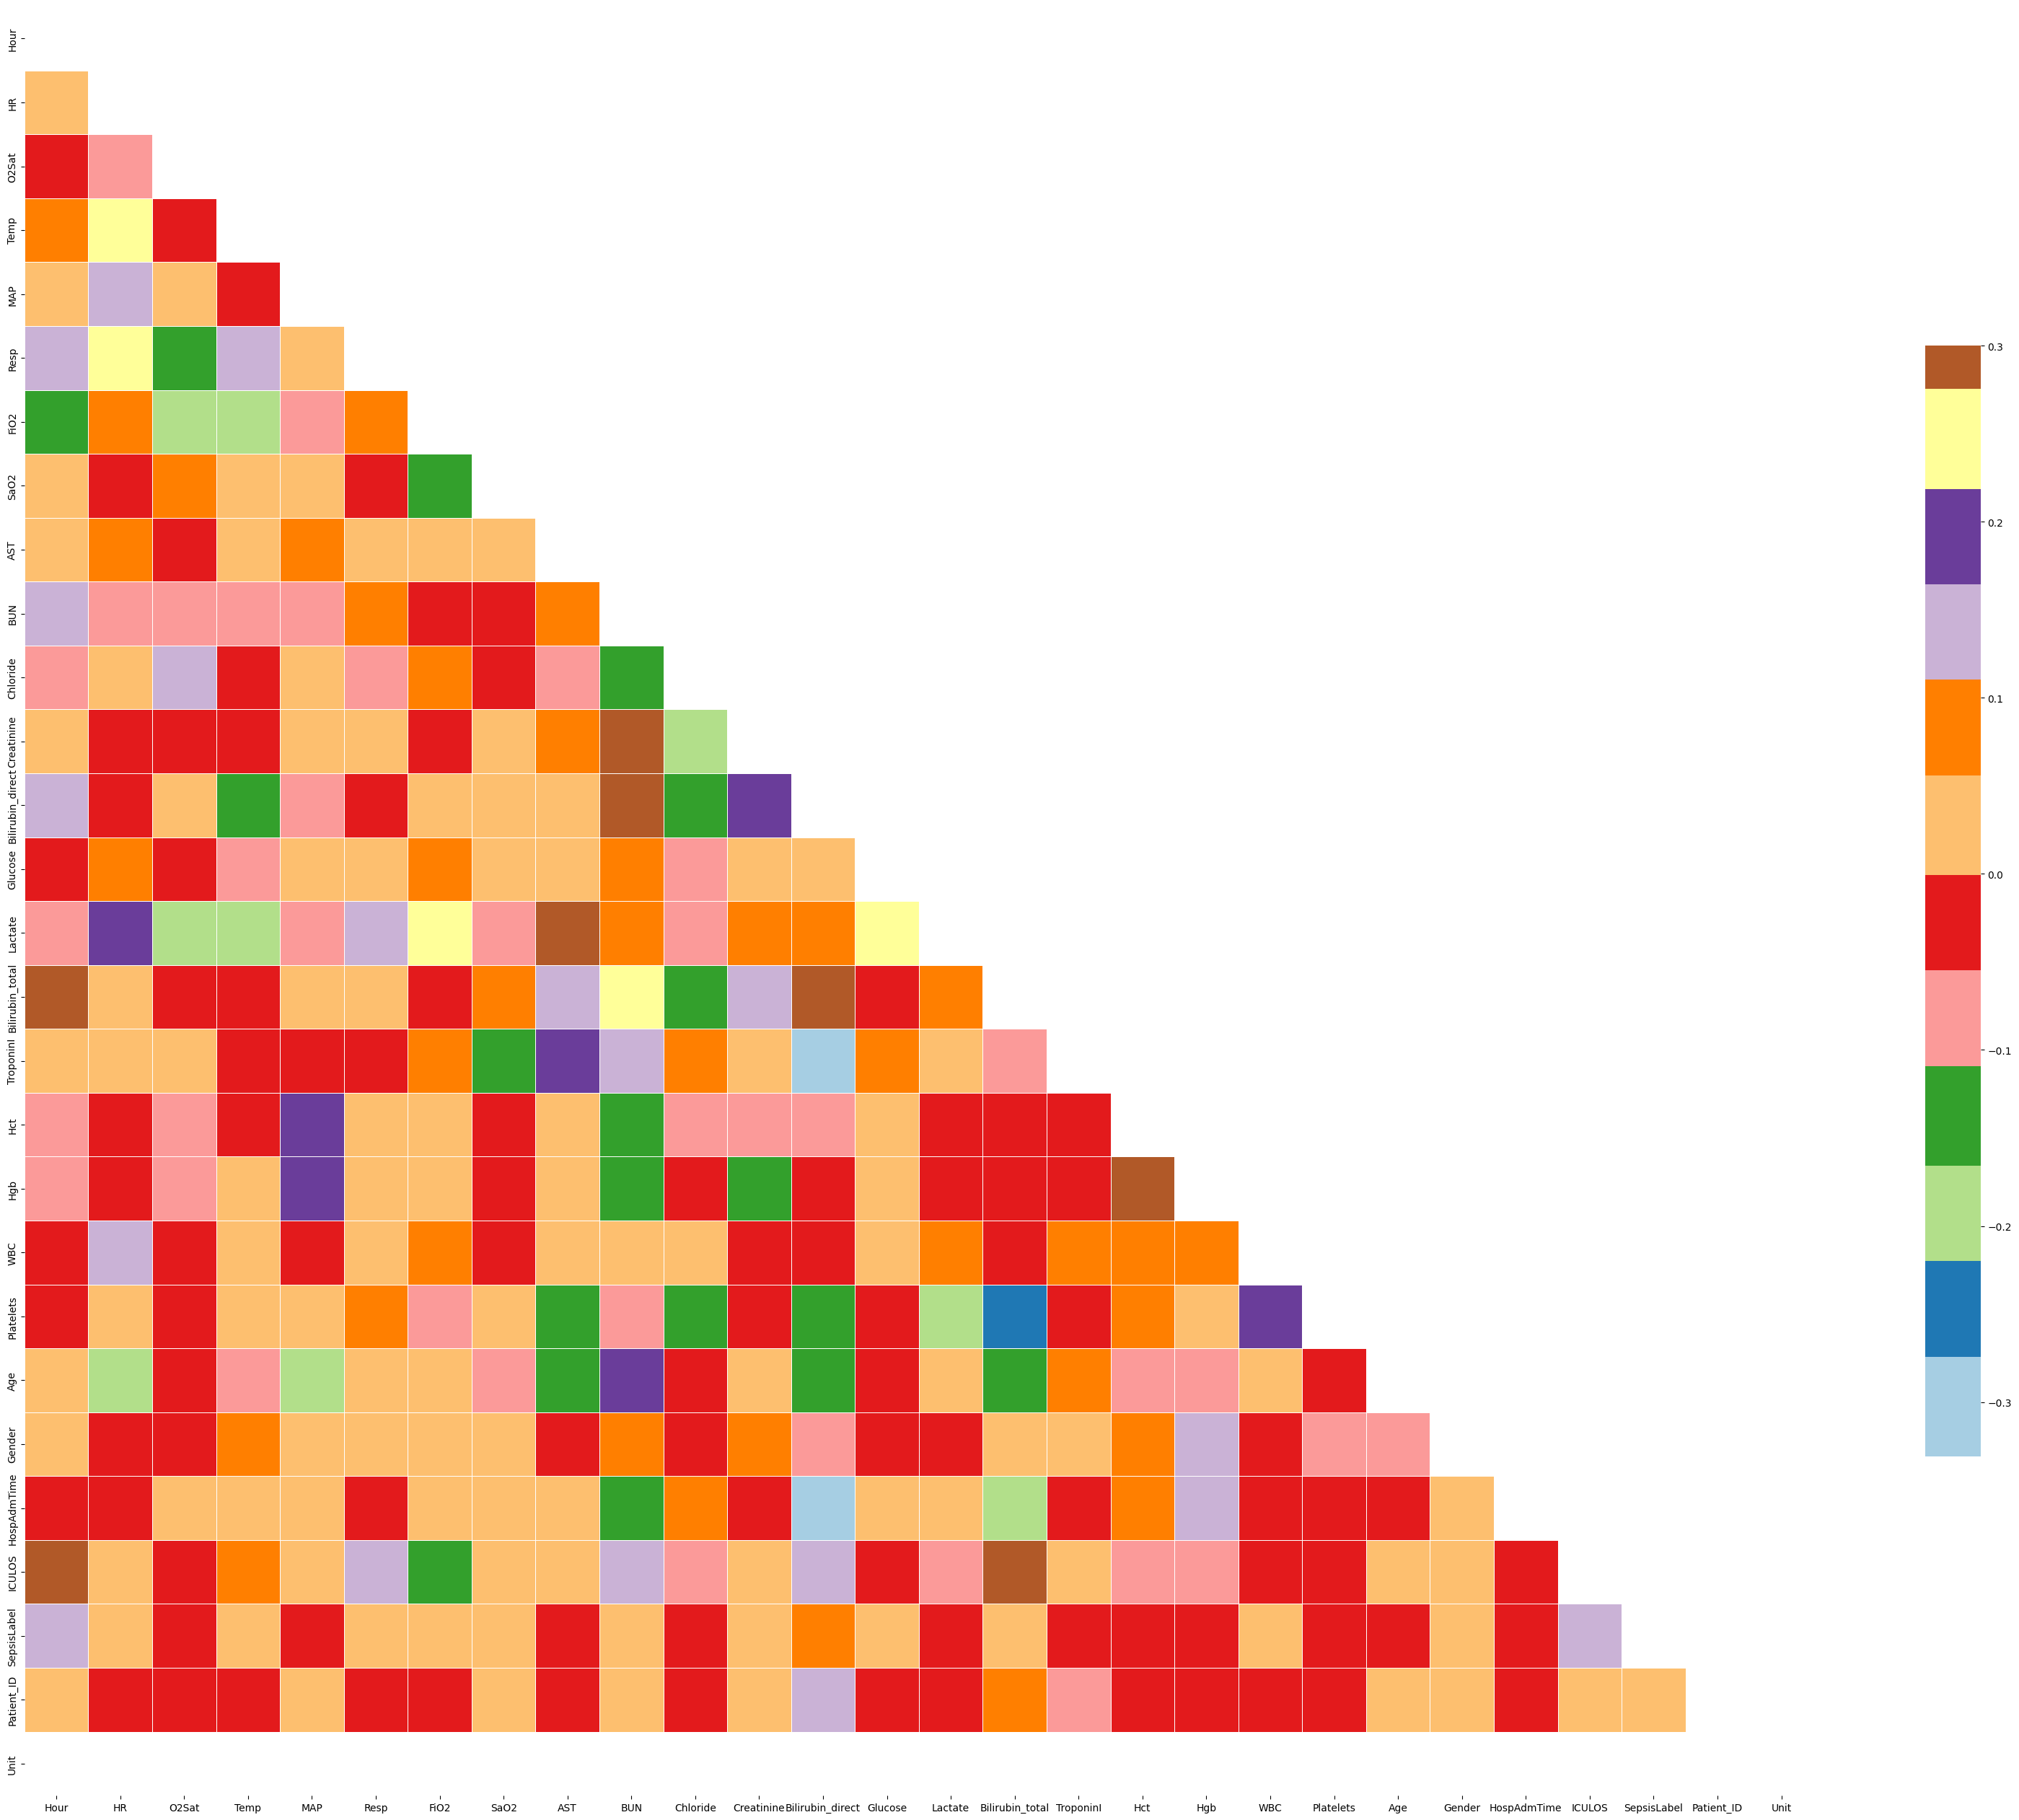

In [10]:
# correlation matrix to check if there is high correlation between the remaining features

corr_matrix(df_train_mod)

In [11]:
#Imputation
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

In [12]:
# bfill and ffill for imputing

grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

In [13]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp  FiO2  SaO2   AST  \
Patient_ID                                                                    
1          132940     0   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           132941     1   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           132942     2   89.0   99.0  36.11  86.00  22.0  0.28  88.0  16.0   
           132943     3   90.0   95.0  36.11  91.33  30.0  0.28  88.0  16.0   
           132944     4  103.0   88.5  36.11  91.33  24.5  0.28  88.0  16.0   

                    BUN  ...   Hgb  WBC  Platelets    Age  Gender  \
Patient_ID               ...                                        
1          132940  14.0  ...  12.5  5.7      317.0  83.14       0   
           132941  14.0  ...  12.5  5.7      317.0  83.14       0   
           132942  14.0  ...  12.5  5.7      317.0  83.14       0   
           132943  14.0  ...  12.5  5.7      317.0  83.14       0   
           132944  14.0  ...  12.5  5.7      317.0  83.14       0   

                   HospAdmTime  ICULOS  SepsisLabel  Patient_ID  Unit  
Patient_ID                                                             
1          132940        -0.03       1            0           1   NaN  
           132941        -0.03       2            0           1   NaN  
           132942        -0.03       3            0           1   NaN  
           132943        -0.03       4            0           1   NaN  
           132944        -0.03       5            0           1   NaN  

[5 rows x 28 columns]

In [14]:
# Now let's check the remaining proportion of missing values

null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

TroponinI           97.357934
Bilirubin_direct    96.256841
Bilirubin_total     66.949754
AST                 66.435590
SaO2                57.282891
Lactate             55.997418
Unit                48.868346
FiO2                36.195592
WBC                  1.511994
Platelets            1.394810
Chloride             1.310656
Hgb                  1.158672
Creatinine           1.029467
Glucose              0.940630
BUN                  0.937719
Temp                 0.853692
Hct                  0.779028
Resp                 0.088710
O2Sat                0.026702
MAP                  0.003037
HR                   0.001139
HospAdmTime          0.001012
Age                  0.000000
Gender               0.000000
ICULOS               0.000000
SepsisLabel          0.000000
Patient_ID           0.000000
Hour                 0.000000
dtype: float64

In [15]:
# dropping all the columns with null values more than 25% and patient_id

null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [16]:
# onehot encoding the gender

one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)

In [17]:
# function to draw histogram and QQ plot

def diagnostic_plots(df, variable):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(121)
    df[variable].hist(bins=30)
    ax = fig.add_subplot(122)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.xlabel(variable)
    plt.show()

In [18]:
def try_gaussian(df, col):
    print(f'Actual plot for {col}')
    diagnostic_plots(df, col)

    # Handle missing or infinite values
    df_col = df[col].replace([np.inf, -np.inf], np.nan).dropna()
    df.dropna(subset=[col], inplace=True)
    df[col].fillna(df[col].mean(), inplace=True)

    # Apply Yeo-Johnson transformation
    try:
        df[f'{col}_yj'], param = stats.yeojohnson(df_col)
        print(f'Yeo-Johnson plot for {col}')
        diagnostic_plots(df, f'{col}_yj')
    except Exception as e:
        print(f"Yeo-Johnson transformation failed for {col}: {e}")

    # Apply exponential transformation
    try:
        df[f'{col}_1.5'] = df_col ** (1/1.5)
        print(f'**1/1.5 plot for {col}')
        diagnostic_plots(df, f'{col}_1.5')
    except Exception as e:
        print(f"Exponential transformation failed for {col}: {e}")

    # Apply square root transformation
    try:
        df[f'{col}_0.5'] = df_col ** 0.5
        print(f'**0.5 plot for {col}')
        diagnostic_plots(df, f'{col}_0.5')
    except Exception as e:
        print(f"Square root transformation failed for {col}: {e}")

    # Apply inverse transformation
    try:
        df[f'{col}_rec'] = 1 / (df_col + 0.00001)
        print(f'Inverse plot for {col}')
        diagnostic_plots(df, f'{col}_rec')
    except Exception as e:
        print(f"Inverse transformation failed for {col}: {e}")

    # Apply logarithmic transformation
    try:
        df[f'{col}_log'] = np.log(df_col + 1)
        print(f'Logarithmic plot for {col}')
        diagnostic_plots(df, f'{col}_log')
    except Exception as e:
        print(f"Logarithmic transformation failed for {col}: {e}")

O2Sat
Actual plot for O2Sat


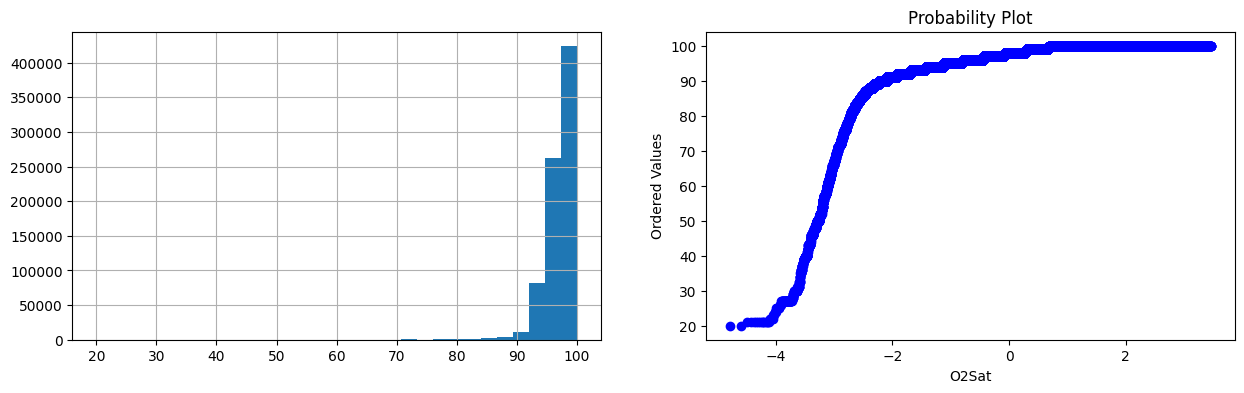

Yeo-Johnson plot for O2Sat


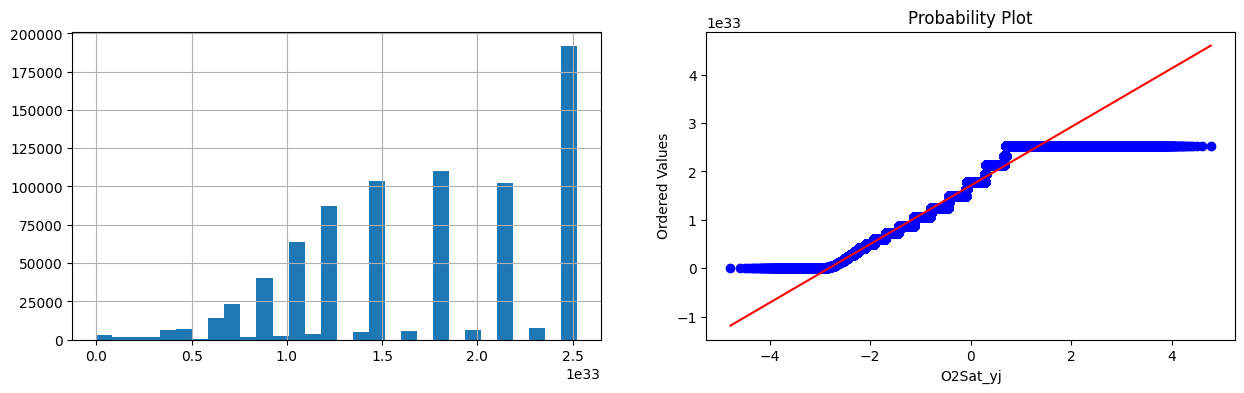

**1/1.5 plot for O2Sat


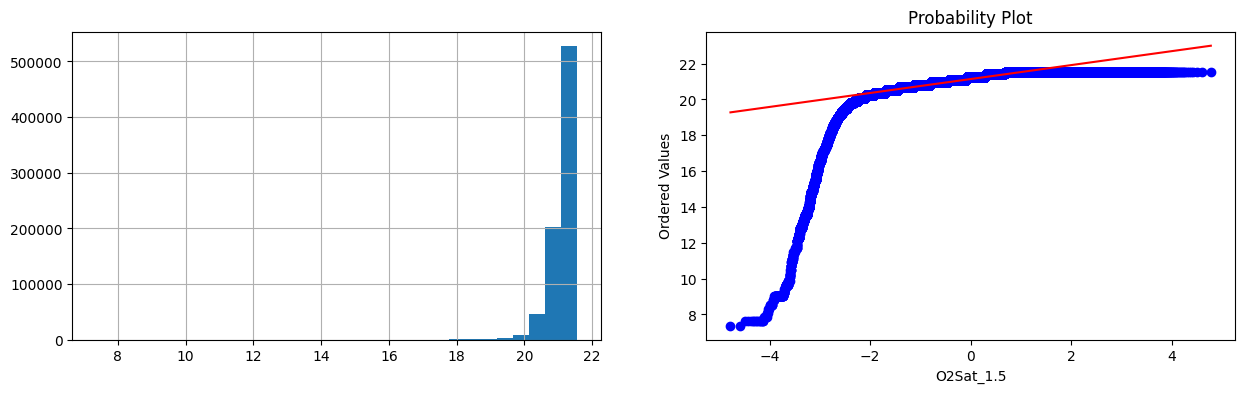

**0.5 plot for O2Sat


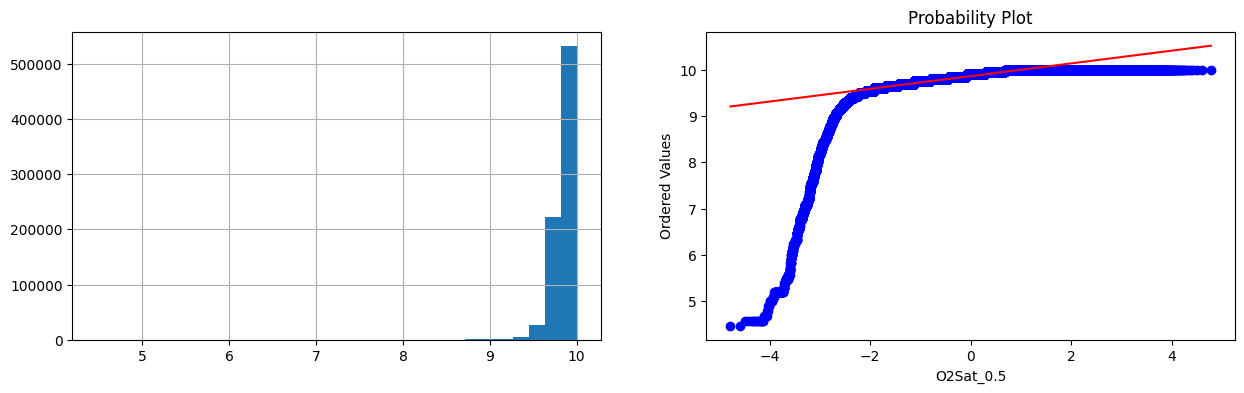

Inverse plot for O2Sat


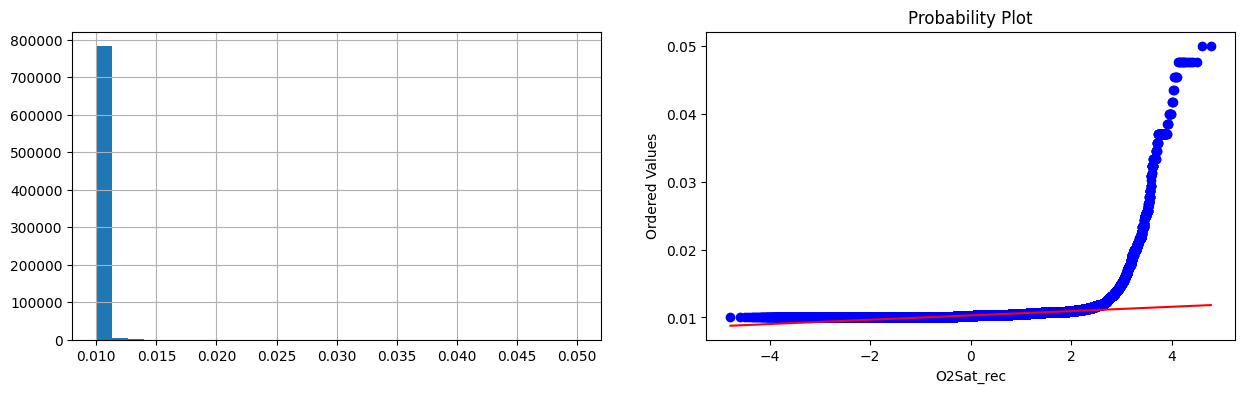

Logarithmic plot for O2Sat


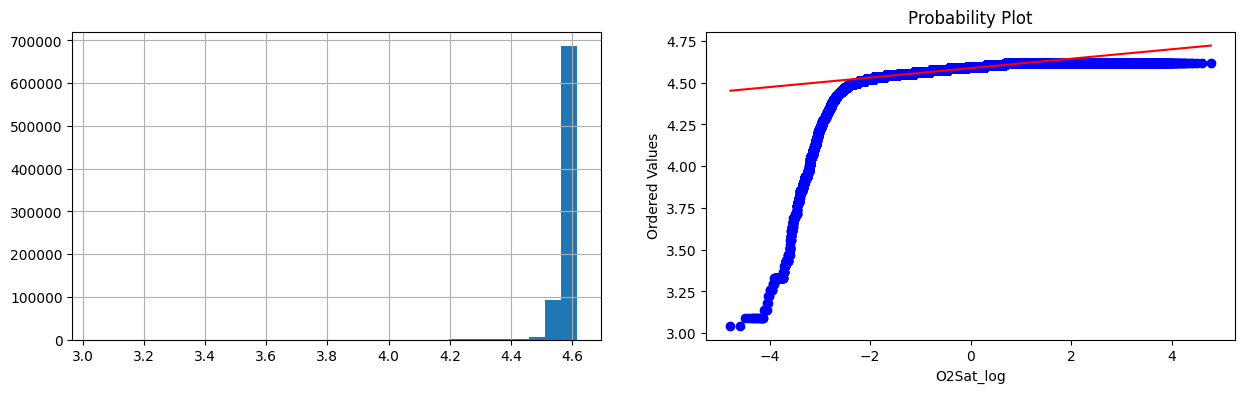

Temp
Actual plot for Temp


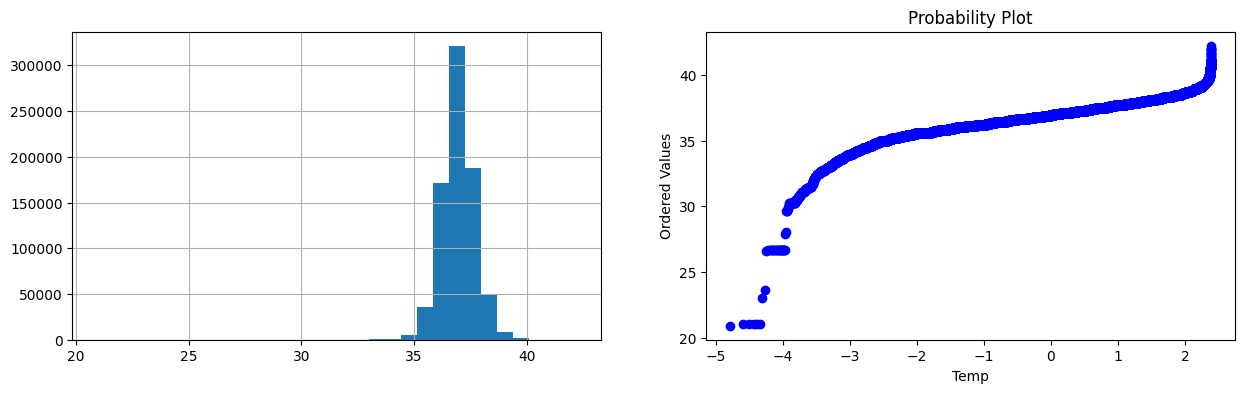

Yeo-Johnson plot for Temp


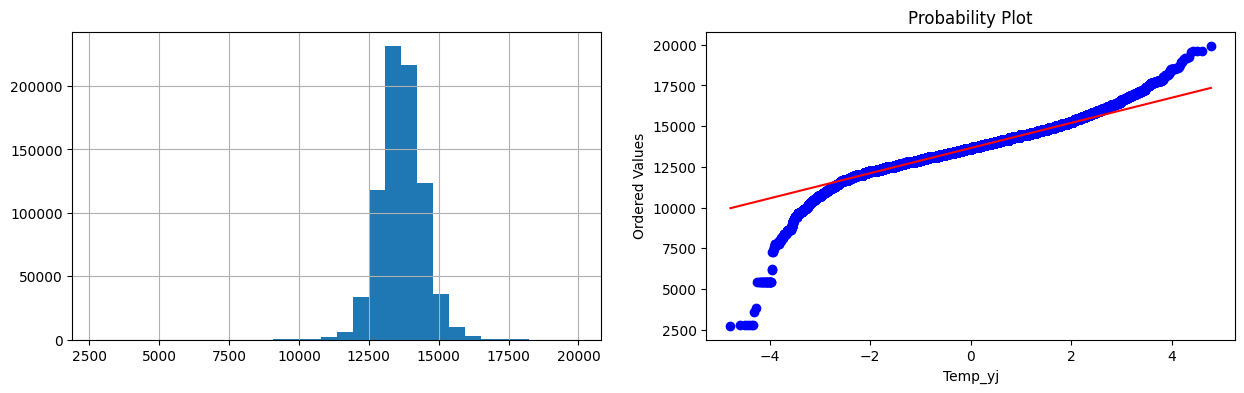

**1/1.5 plot for Temp


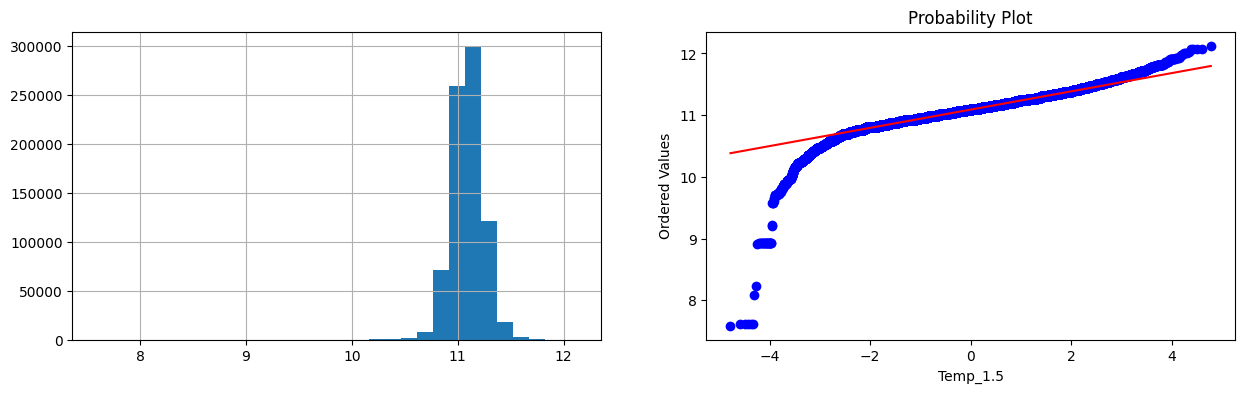

**0.5 plot for Temp


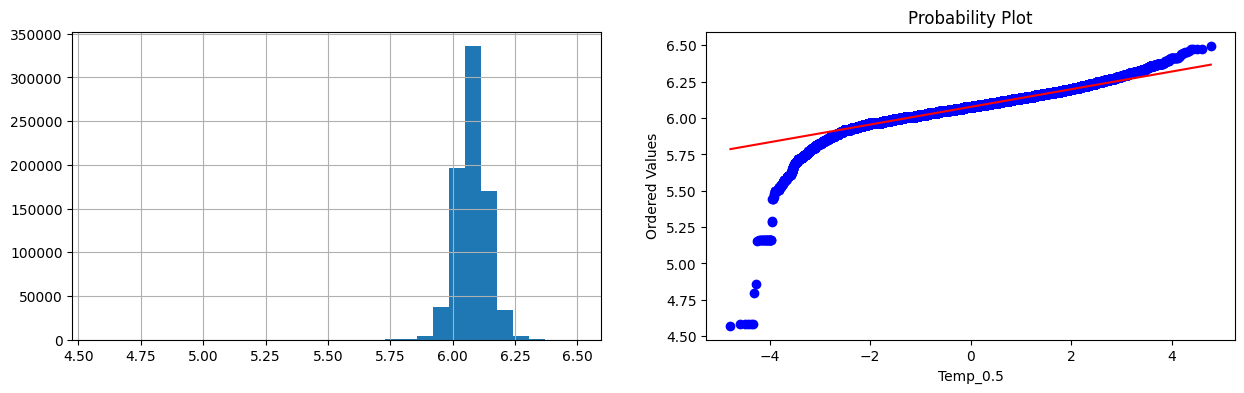

Inverse plot for Temp


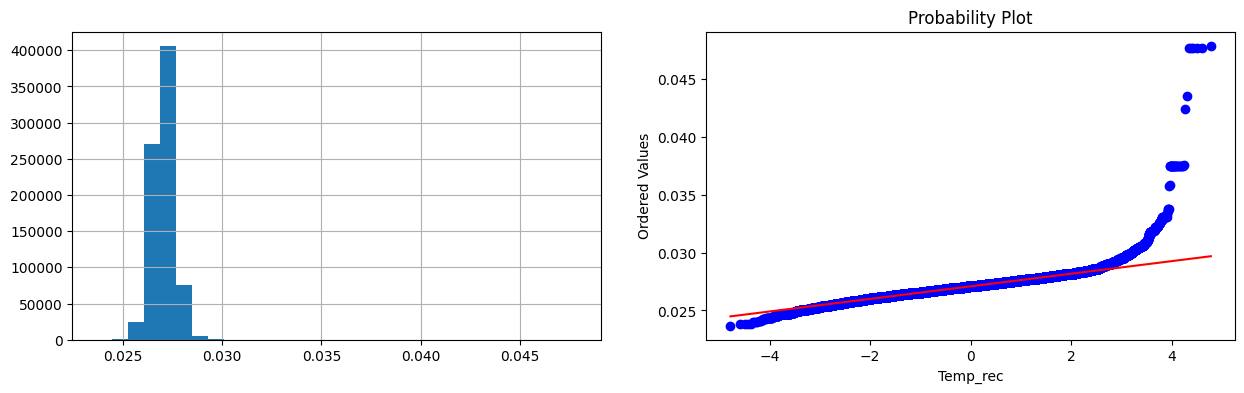

Logarithmic plot for Temp


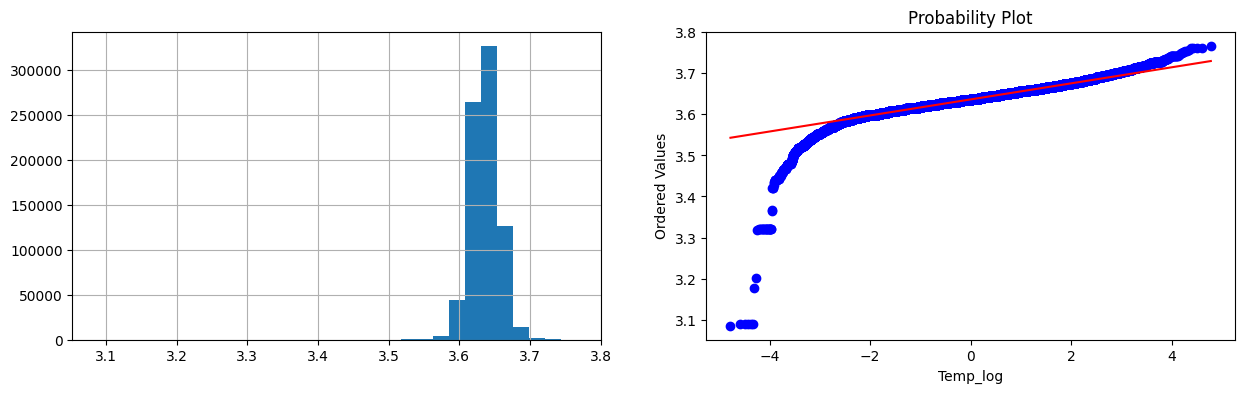

MAP
Actual plot for MAP


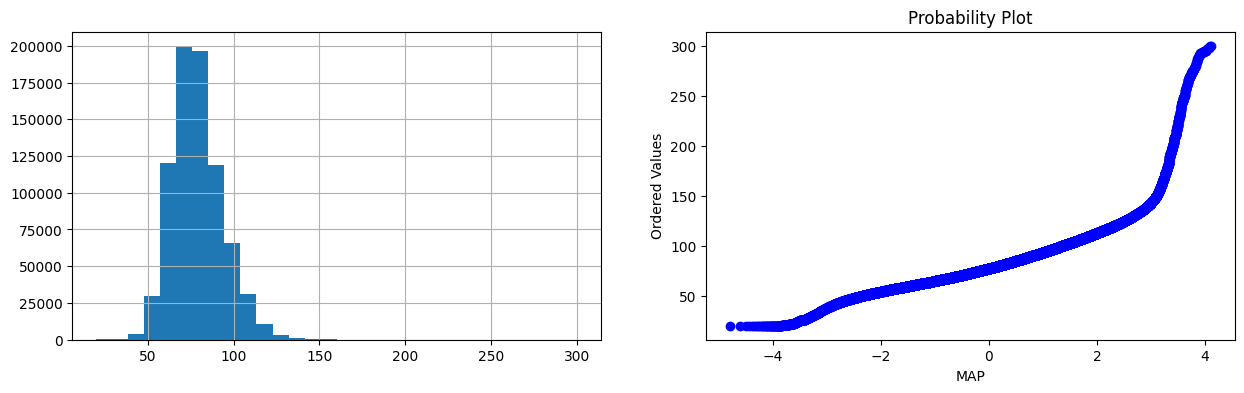

Yeo-Johnson plot for MAP


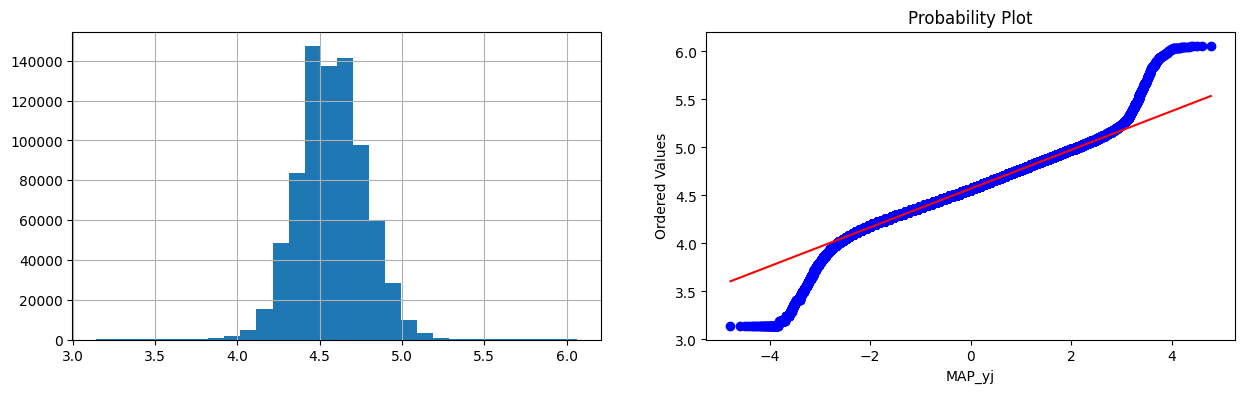

**1/1.5 plot for MAP


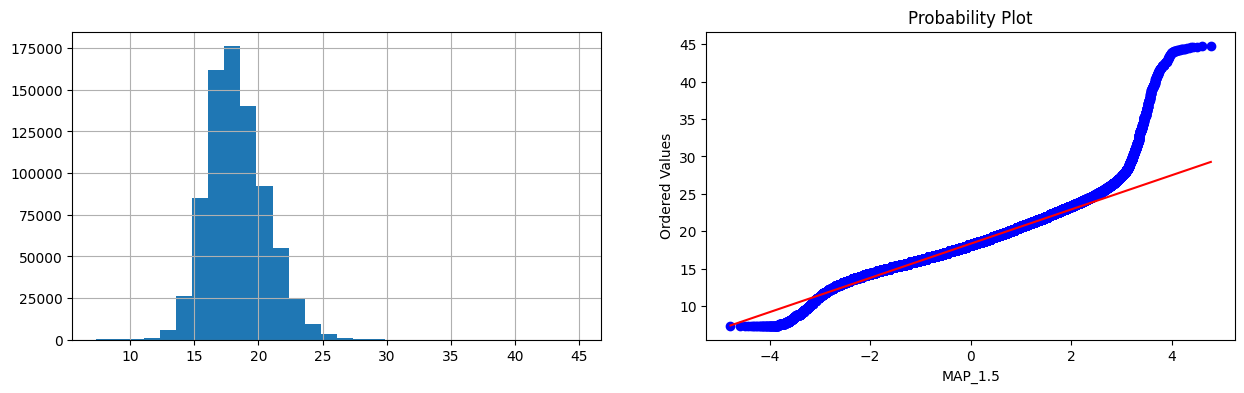

**0.5 plot for MAP


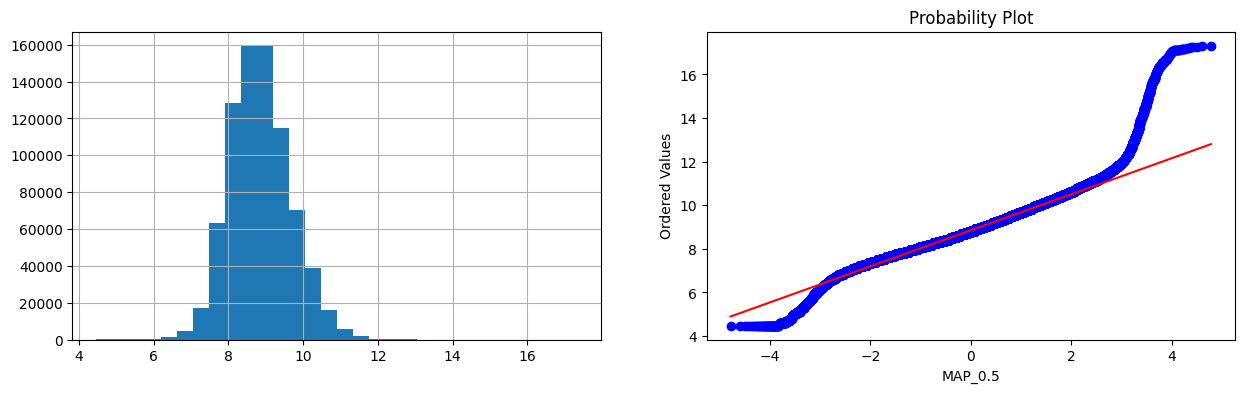

Inverse plot for MAP


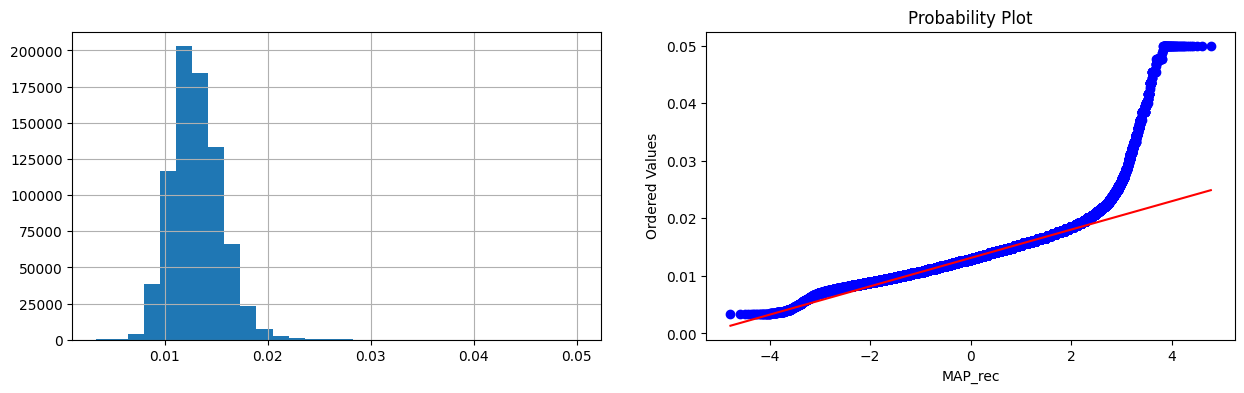

Logarithmic plot for MAP


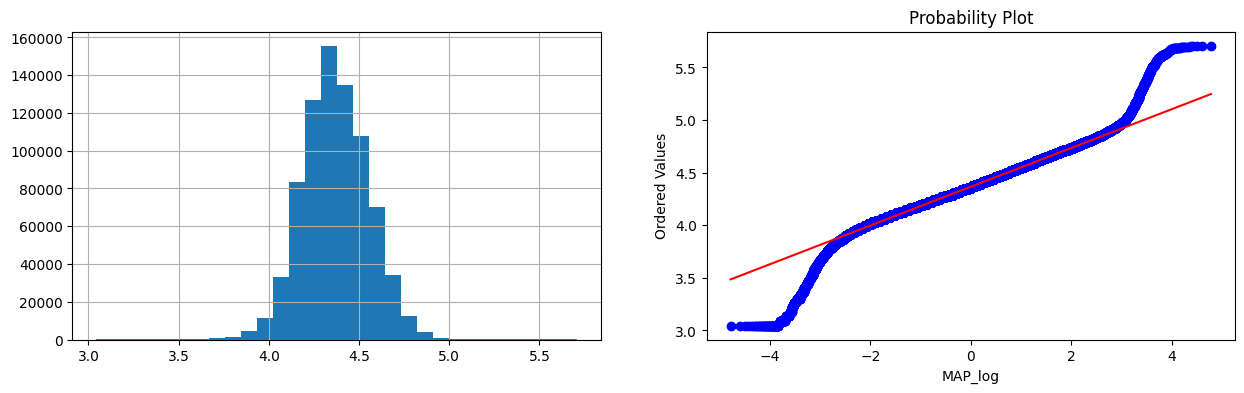

BUN
Actual plot for BUN


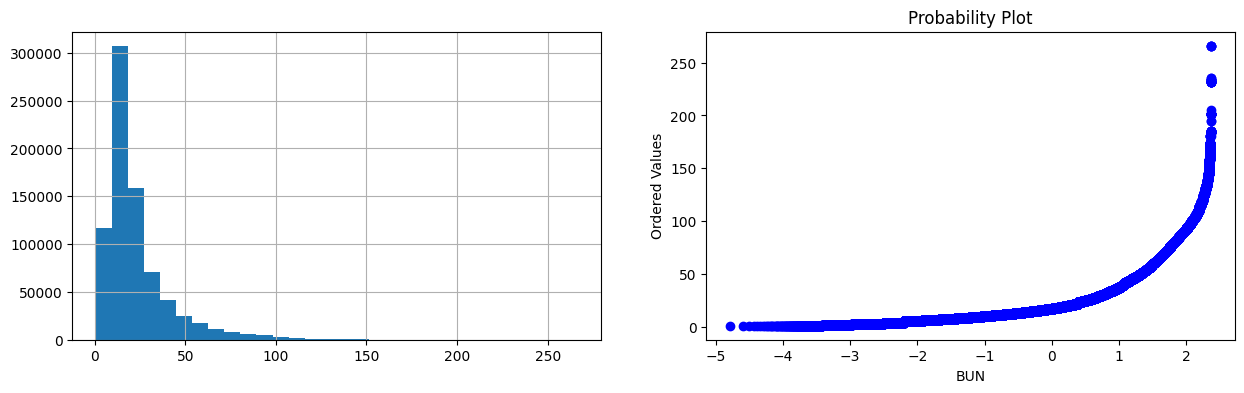

Yeo-Johnson plot for BUN


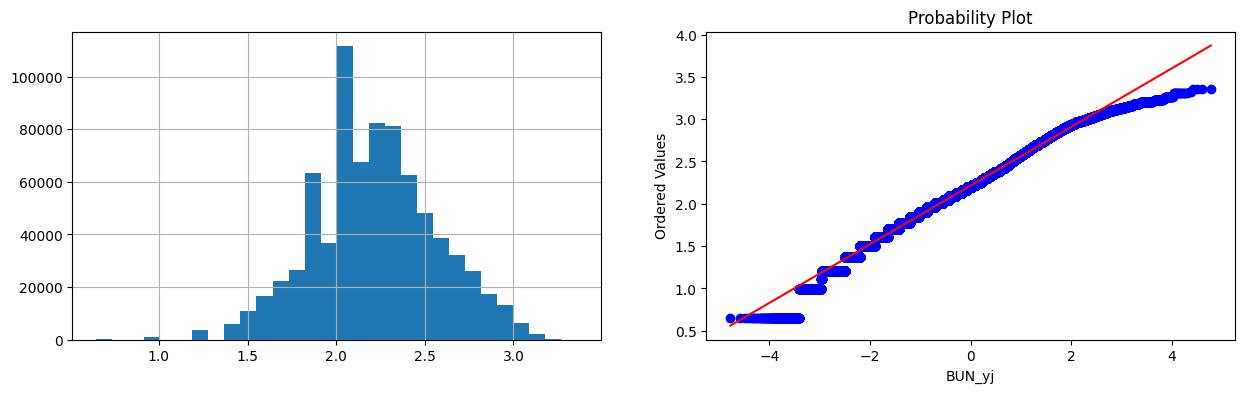

**1/1.5 plot for BUN


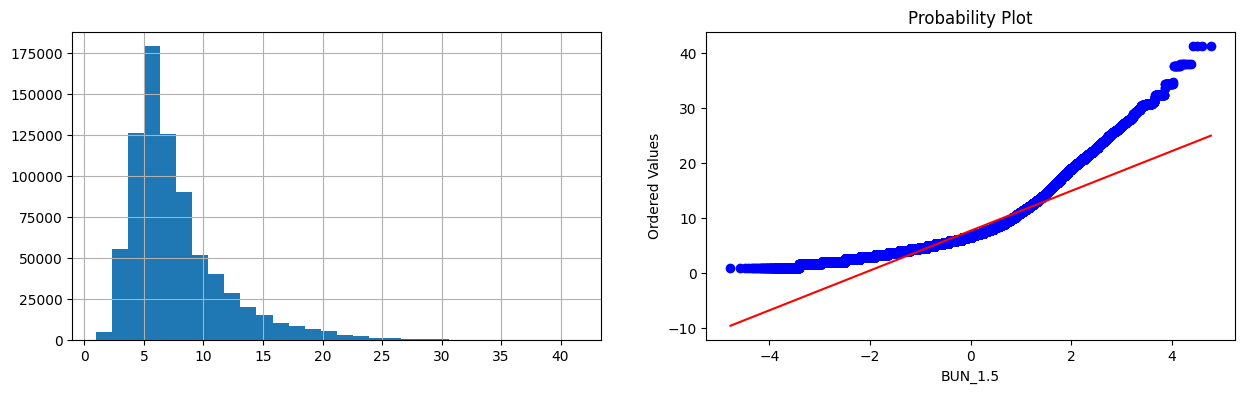

**0.5 plot for BUN


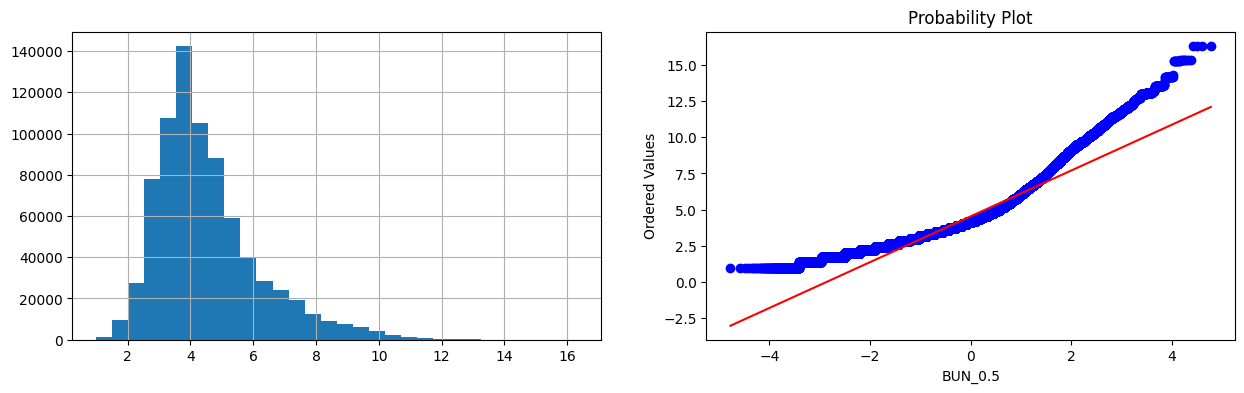

Inverse plot for BUN


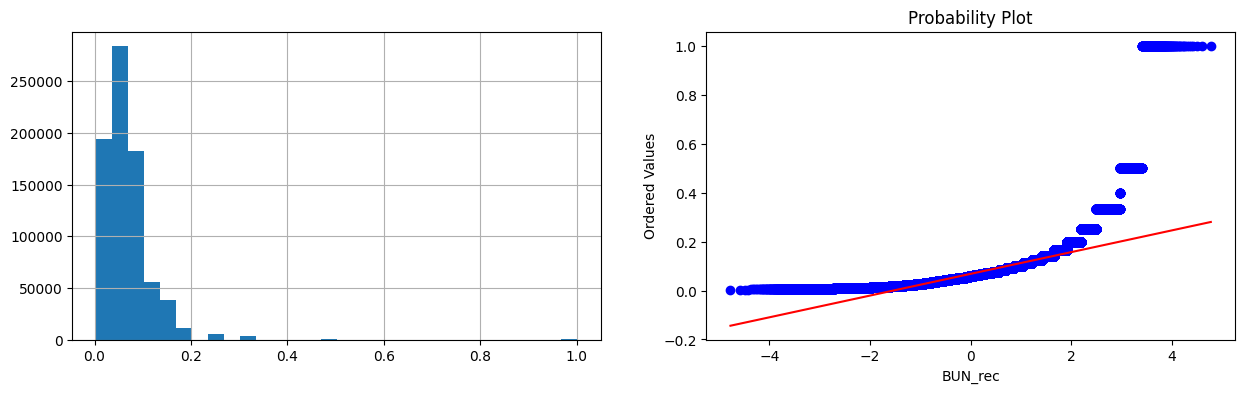

Logarithmic plot for BUN


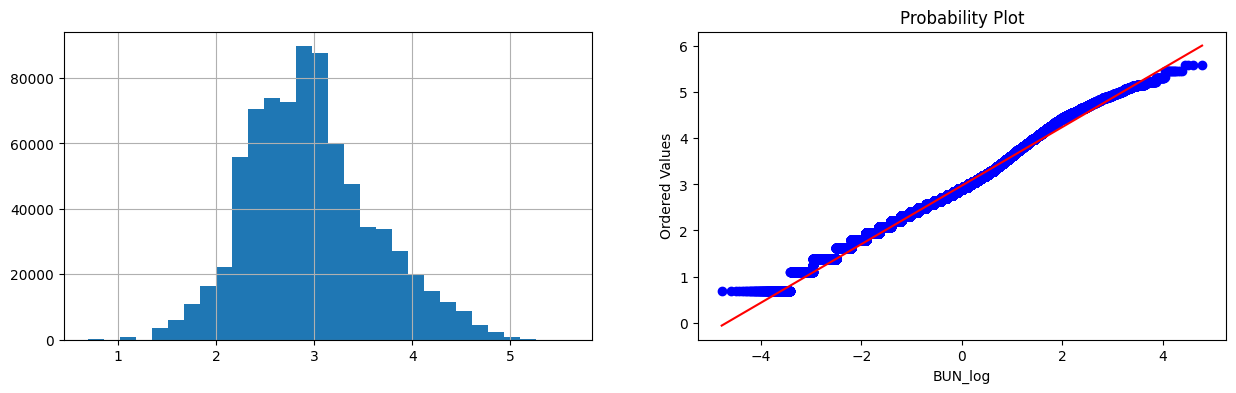

Creatinine
Actual plot for Creatinine


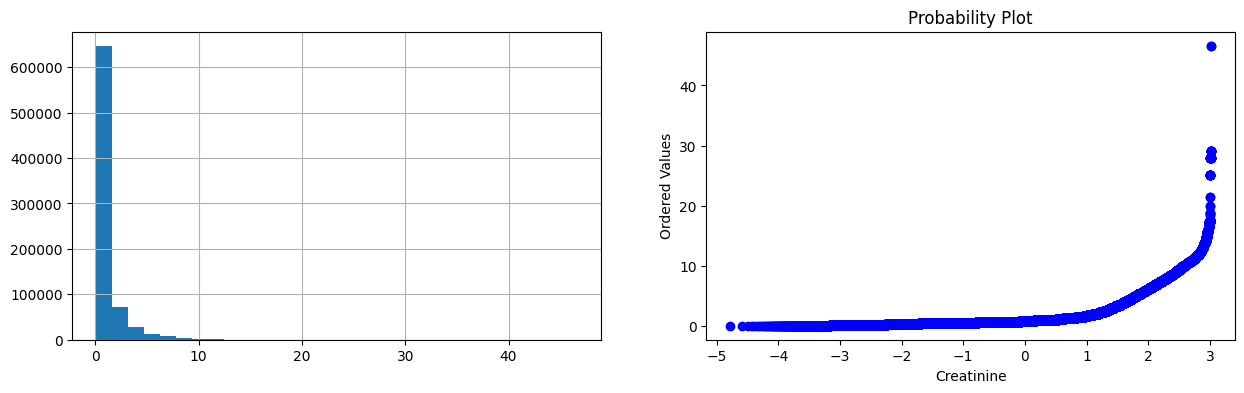

Yeo-Johnson plot for Creatinine


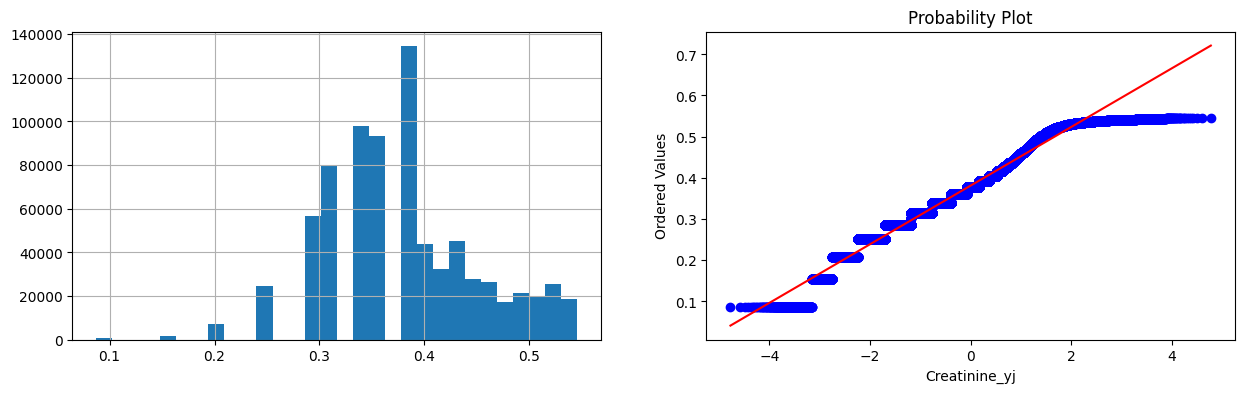

**1/1.5 plot for Creatinine


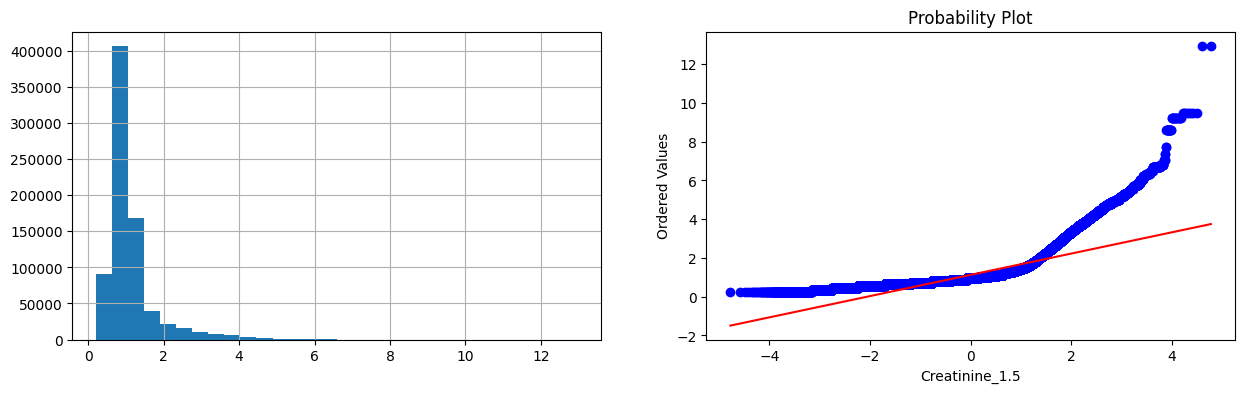

**0.5 plot for Creatinine


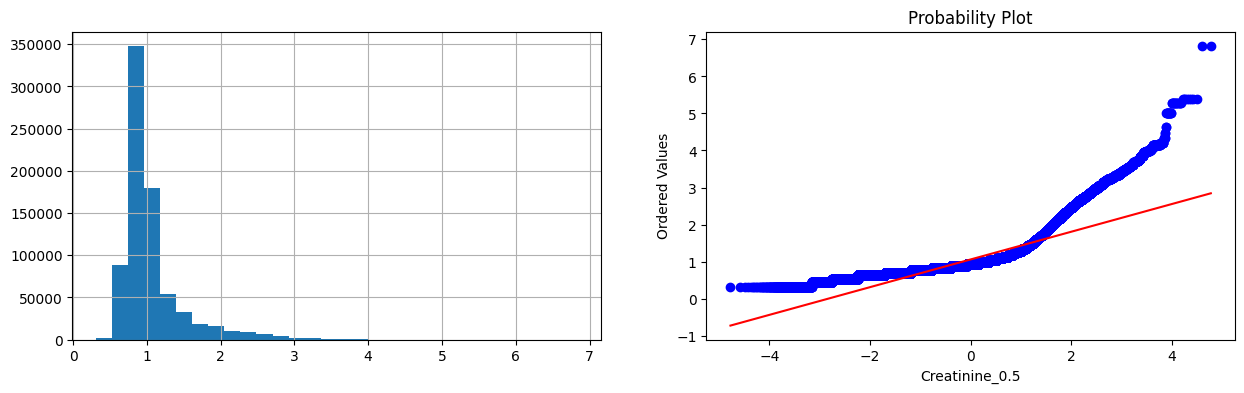

Inverse plot for Creatinine


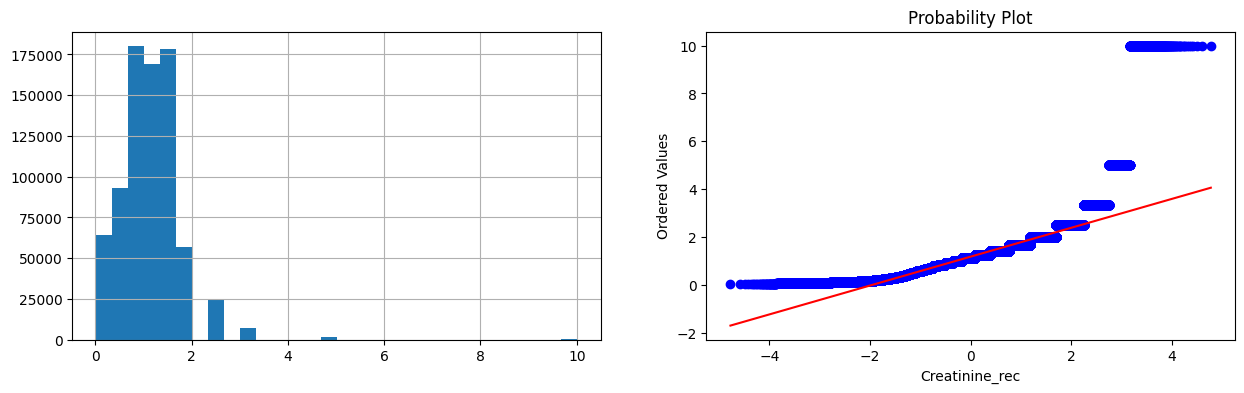

Logarithmic plot for Creatinine


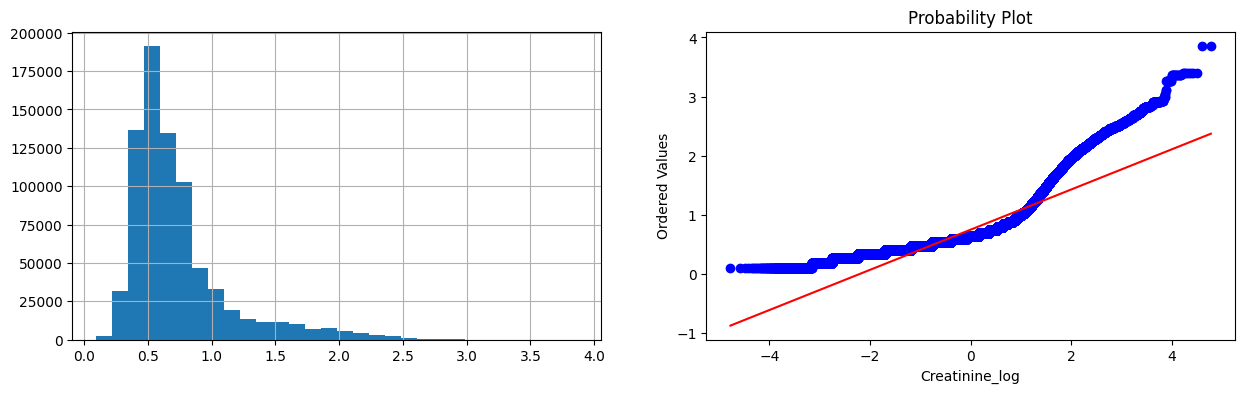

Glucose
Actual plot for Glucose


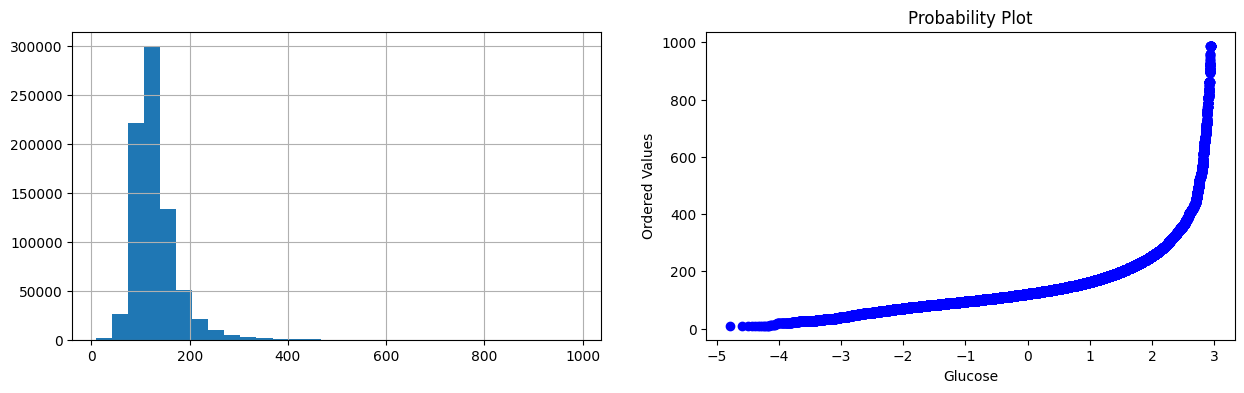

Yeo-Johnson plot for Glucose


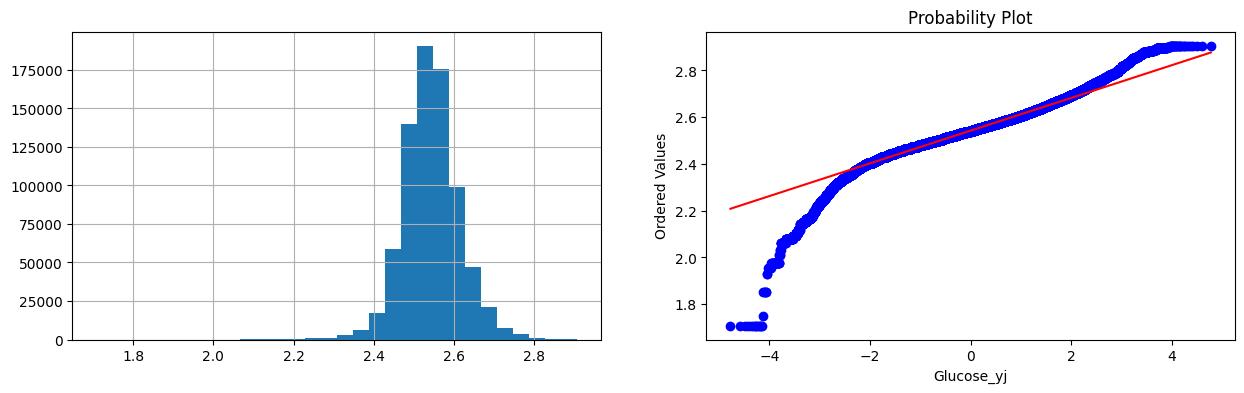

**1/1.5 plot for Glucose


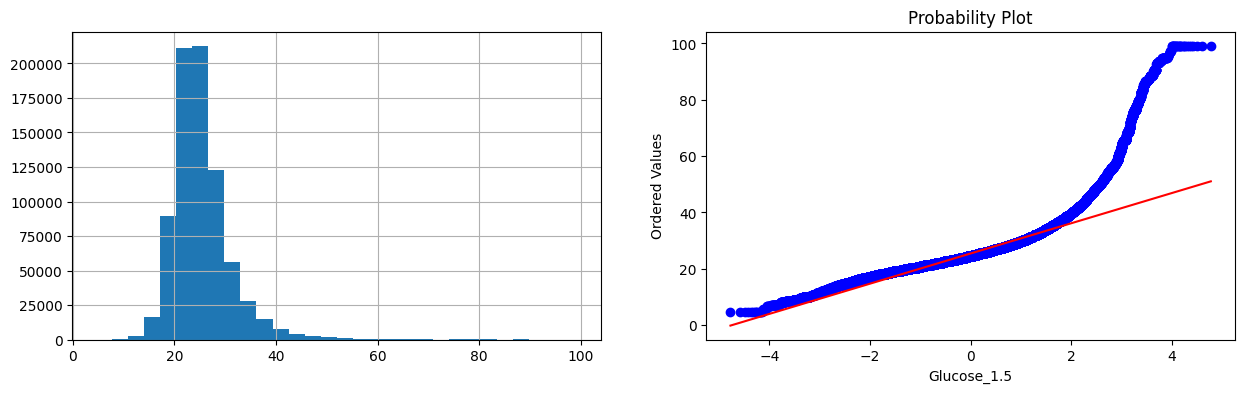

**0.5 plot for Glucose


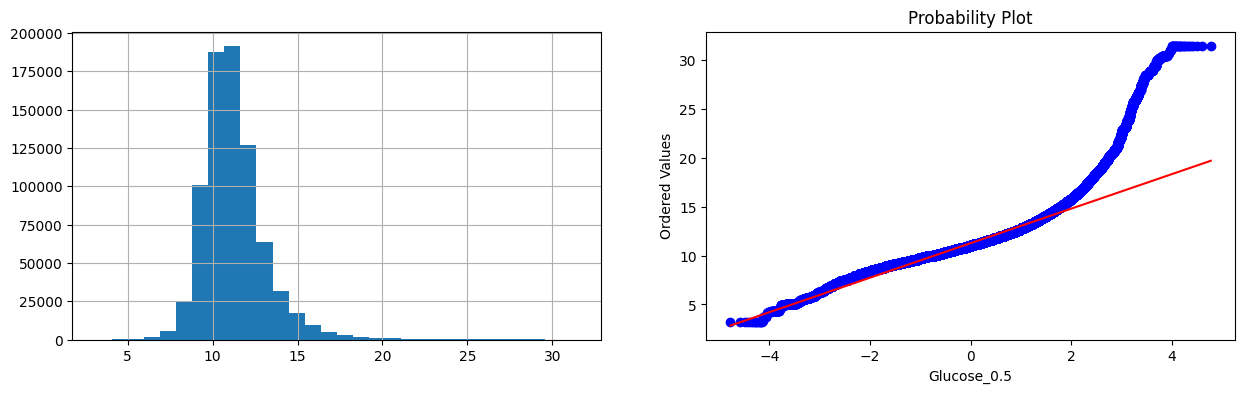

Inverse plot for Glucose


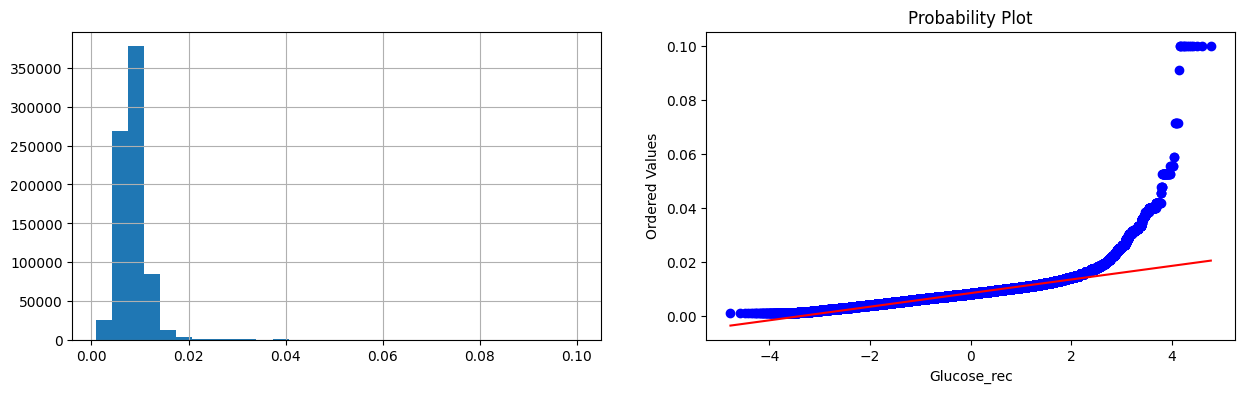

Logarithmic plot for Glucose


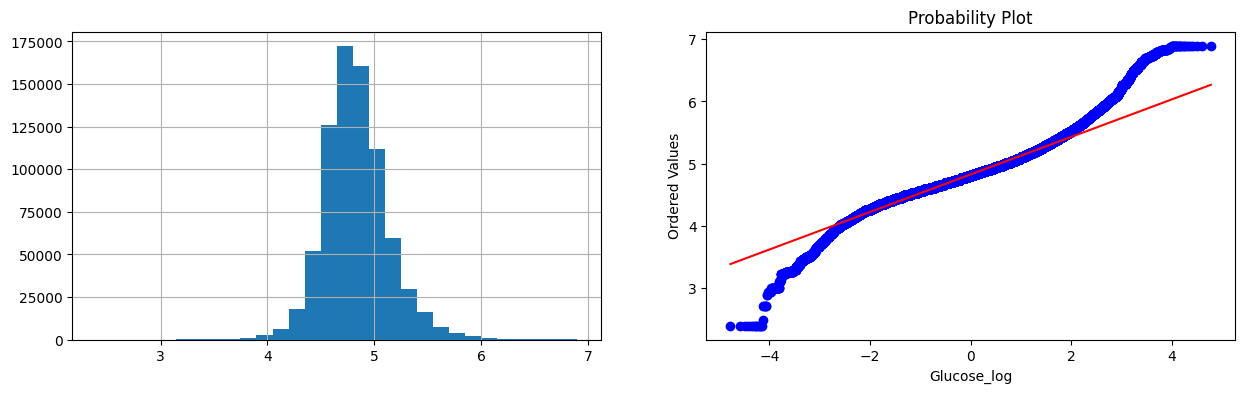

WBC
Actual plot for WBC


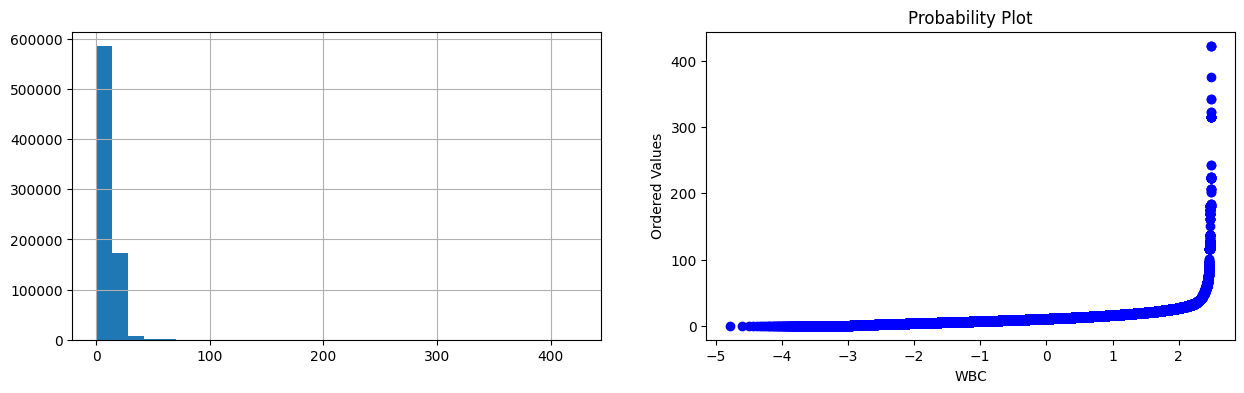

Yeo-Johnson plot for WBC


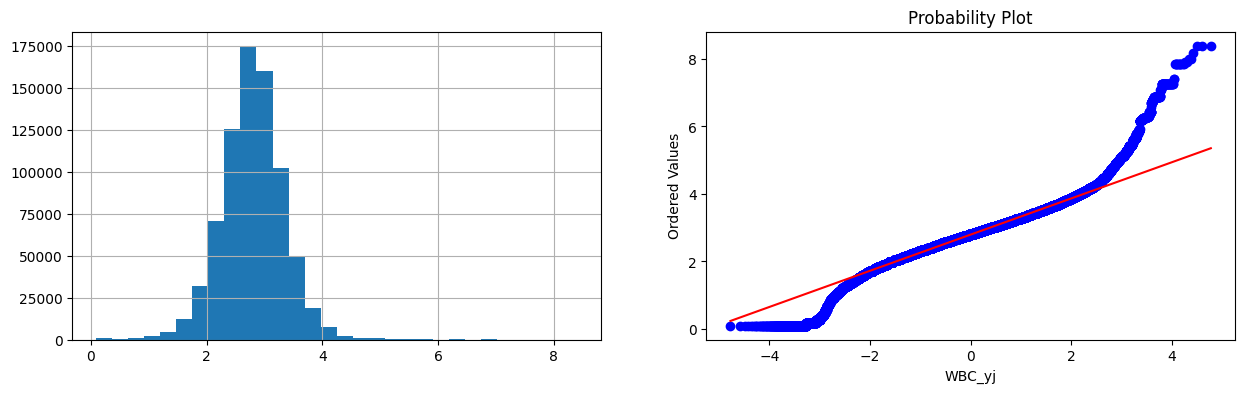

**1/1.5 plot for WBC


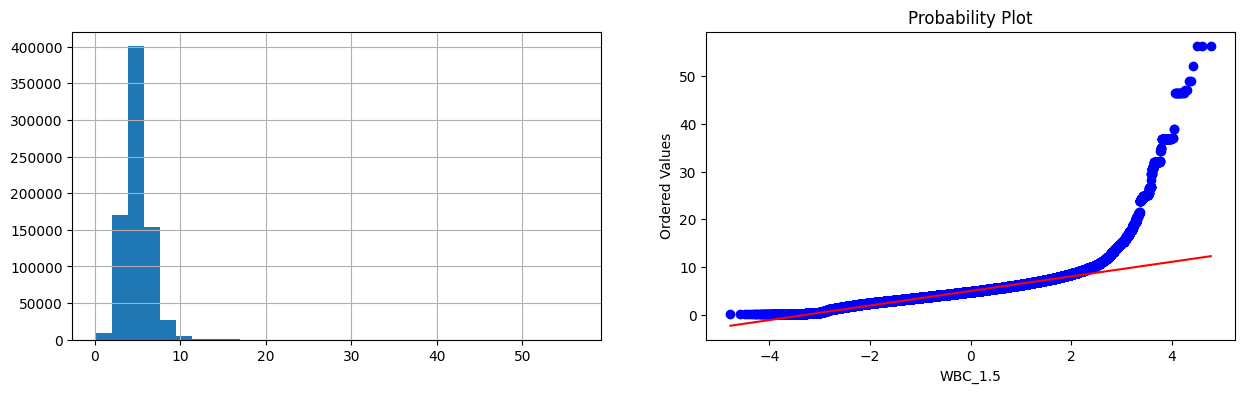

**0.5 plot for WBC


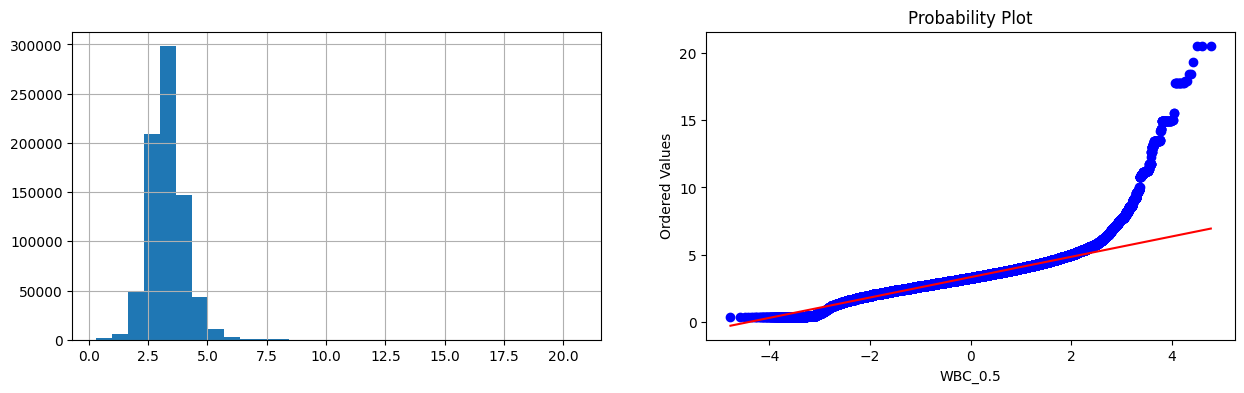

Inverse plot for WBC


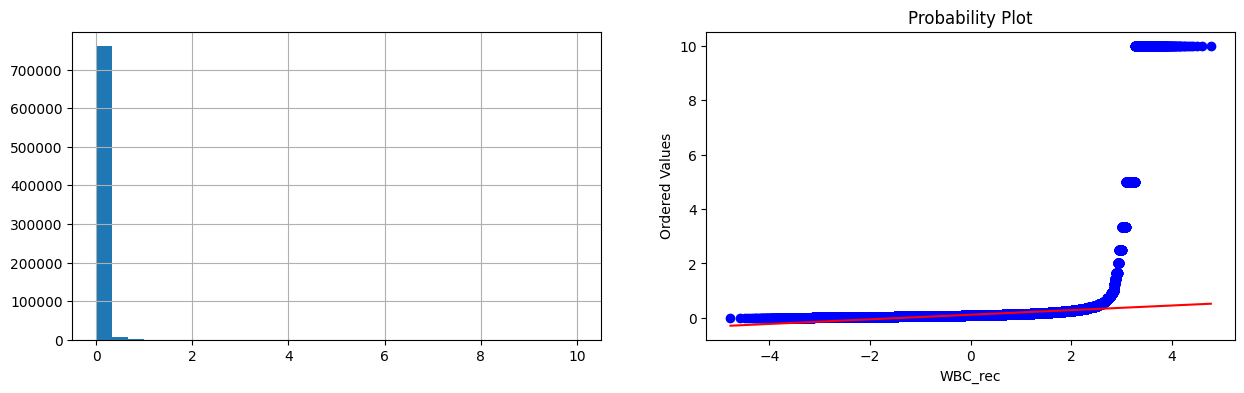

Logarithmic plot for WBC


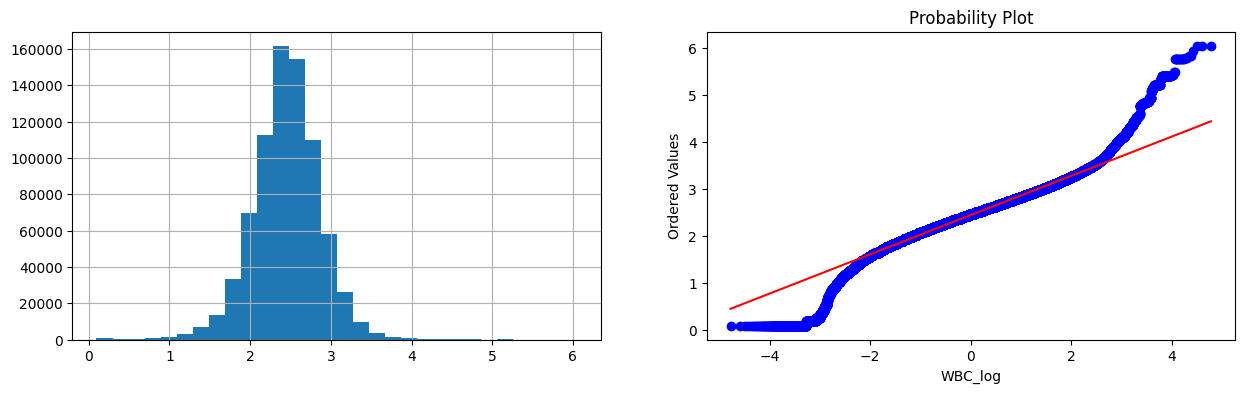

Platelets
Actual plot for Platelets


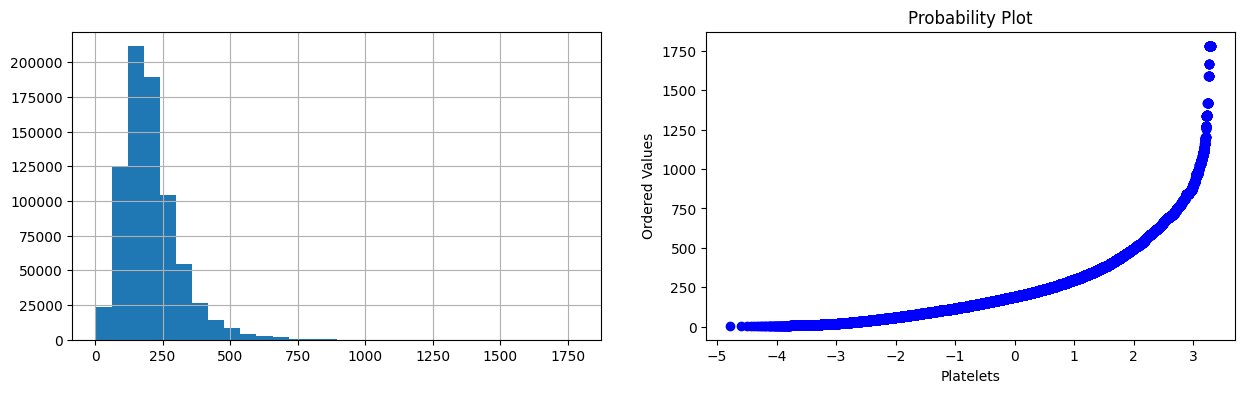

Yeo-Johnson plot for Platelets


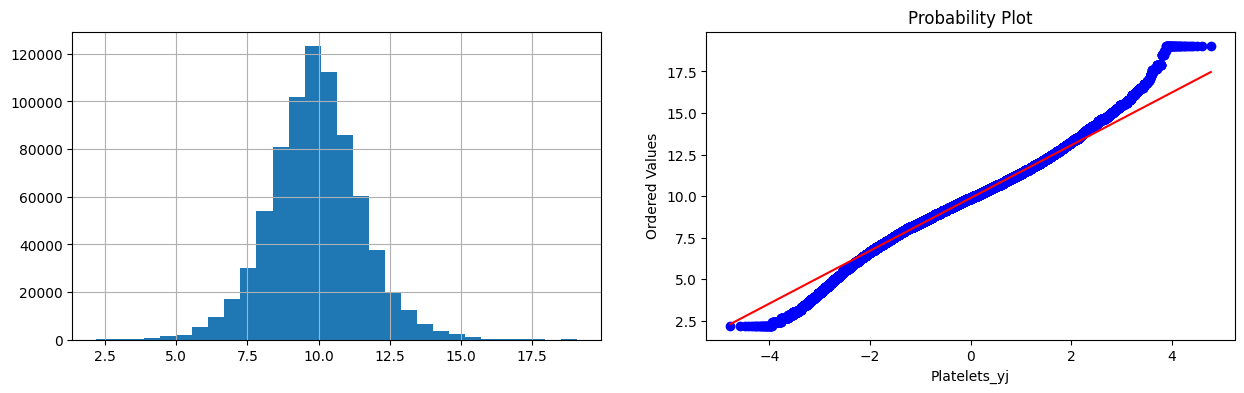

**1/1.5 plot for Platelets


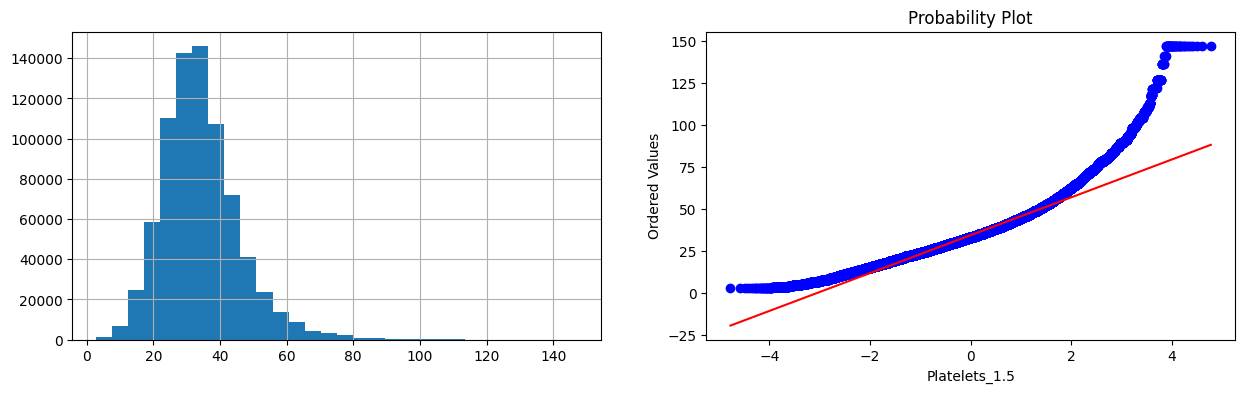

**0.5 plot for Platelets


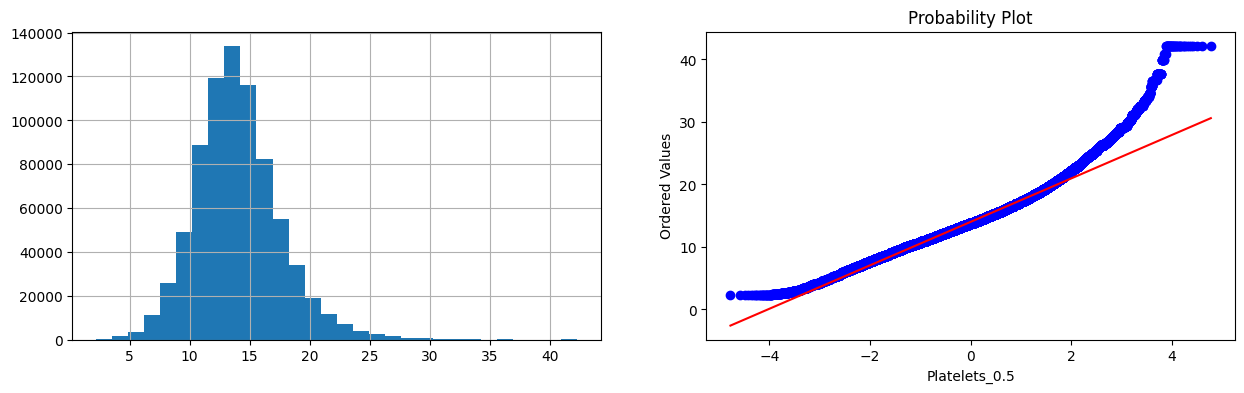

Inverse plot for Platelets


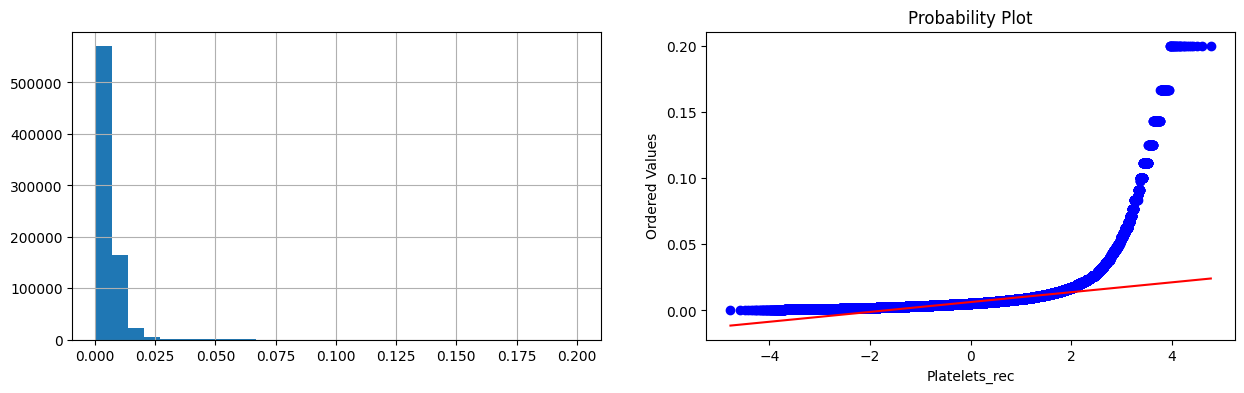

Logarithmic plot for Platelets


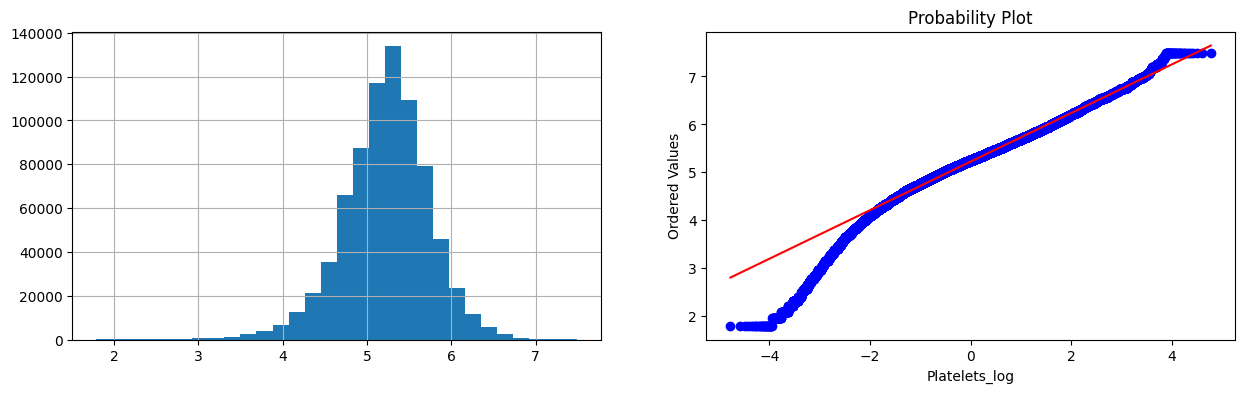

In [19]:
# try normal distribution
# Now we try to check the distribution of values present in different columns after application of various transformations

lst = ['O2Sat', 'Temp', 'MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in lst:
  print(i)
  try_gaussian(df_train_impute, i)

In [20]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp   BUN  Chloride  \
Patient_ID                                                                  
1          132940     0   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           132941     1   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           132942     2   89.0   99.0  36.11  86.00  22.0  14.0      85.0   
           132943     3   90.0   95.0  36.11  91.33  30.0  14.0      85.0   
           132944     4  103.0   88.5  36.11  91.33  24.5  14.0      85.0   

                   Creatinine  Glucose  ...    WBC_yj   WBC_1.5   WBC_0.5  \
Patient_ID                              ...                                 
1          132940         0.7    193.0  ...  2.101289  3.190925  2.387467   
           132941         0.7    193.0  ...  2.101289  3.190925  2.387467   
           132942         0.7    193.0  ...  2.101289  3.190925  2.387467   
           132943         0.7    193.0  ...  2.101289  3.190925  2.387467   
           132944         0.7    193.0  ...  2.101289  3.190925  2.387467   

                    WBC_rec   WBC_log  Platelets_yj  Platelets_1.5  \
Patient_ID                                                           
1          132940  0.175438  1.902108      11.60578      46.491423   
           132941  0.175438  1.902108      11.60578      46.491423   
           132942  0.175438  1.902108      11.60578      46.491423   
           132943  0.175438  1.902108      11.60578      46.491423   
           132944  0.175438  1.902108      11.60578      46.491423   

                   Platelets_0.5  Platelets_rec  Platelets_log  
Patient_ID                                                      
1          132940      17.804494       0.003155       5.762051  
           132941      17.804494       0.003155       5.762051  
           132942      17.804494       0.003155       5.762051  
           132943      17.804494       0.003155       5.762051  
           132944      17.804494       0.003155       5.762051  

[5 rows x 60 columns]

In [21]:
# by oserving different plots, it can be concluded that only log was somewhat effective and that too for MAP, BUN, Creatinine, Glucose, WBC & Plateletes
# therefore applying log transformations on the above columns

columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

In [22]:
df_train_impute.head()

Hour     HR  O2Sat   Temp       MAP  Resp      BUN  \
Patient_ID                                                              
1          132940     0   97.0   95.0  36.11  4.335066  19.0  2.70805   
           132941     1   97.0   95.0  36.11  4.335066  19.0  2.70805   
           132942     2   89.0   99.0  36.11  4.465908  22.0  2.70805   
           132943     3   90.0   95.0  36.11  4.525369  30.0  2.70805   
           132944     4  103.0   88.5  36.11  4.525369  24.5  2.70805   

                   Chloride  Creatinine   Glucose  ...    WBC_yj   WBC_1.5  \
Patient_ID                                         ...                       
1          132940      85.0    0.530628  5.267858  ...  2.101289  3.190925   
           132941      85.0    0.530628  5.267858  ...  2.101289  3.190925   
           132942      85.0    0.530628  5.267858  ...  2.101289  3.190925   
           132943      85.0    0.530628  5.267858  ...  2.101289  3.190925   
           132944      85.0    0.530628  5.267858  ...  2.101289  3.190925   

                    WBC_0.5   WBC_rec   WBC_log  Platelets_yj  Platelets_1.5  \
Patient_ID                                                                     
1          132940  2.387467  0.175438  1.902108      11.60578      46.491423   
           132941  2.387467  0.175438  1.902108      11.60578      46.491423   
           132942  2.387467  0.175438  1.902108      11.60578      46.491423   
           132943  2.387467  0.175438  1.902108      11.60578      46.491423   
           132944  2.387467  0.175438  1.902108      11.60578      46.491423   

                   Platelets_0.5  Platelets_rec  Platelets_log  
Patient_ID                                                      
1          132940      17.804494       0.003155       5.762051  
           132941      17.804494       0.003155       5.762051  
           132942      17.804494       0.003155       5.762051  
           132943      17.804494       0.003155       5.762051  
           132944      17.804494       0.003155       5.762051  

[5 rows x 60 columns]

In [23]:
# standard normalization

scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()

Hour        HR     O2Sat      Temp       MAP      Resp  \
Patient_ID                                                                  
1          132940     0  0.704223 -0.704952 -1.110447 -0.164037  0.041607   
           132941     1  0.704223 -0.704952 -1.110447 -0.164037  0.041607   
           132942     2  0.235166  0.562752 -1.110447  0.544241  0.597660   
           132943     3  0.293798 -0.704952 -1.110447  0.866118  2.080469   
           132944     4  1.056015 -2.764971 -1.110447  0.866118  1.061038   

                       BUN  Chloride  Creatinine   Glucose  ...    WBC_yj  \
Patient_ID                                                  ...             
1          132940 -0.41289 -3.693241   -0.559834  1.446094  ...  2.101289   
           132941 -0.41289 -3.693241   -0.559834  1.446094  ...  2.101289   
           132942 -0.41289 -3.693241   -0.559834  1.446094  ...  2.101289   
           132943 -0.41289 -3.693241   -0.559834  1.446094  ...  2.101289   
           132944 -0.41289 -3.693241   -0.559834  1.446094  ...  2.101289   

                    WBC_1.5   WBC_0.5   WBC_rec   WBC_log  Platelets_yj  \
Patient_ID                                                                
1          132940  3.190925  2.387467  0.175438  1.902108      11.60578   
           132941  3.190925  2.387467  0.175438  1.902108      11.60578   
           132942  3.190925  2.387467  0.175438  1.902108      11.60578   
           132943  3.190925  2.387467  0.175438  1.902108      11.60578   
           132944  3.190925  2.387467  0.175438  1.902108      11.60578   

                   Platelets_1.5  Platelets_0.5  Platelets_rec  Platelets_log  
Patient_ID                                                                     
1          132940      46.491423      17.804494       0.003155       5.762051  
           132941      46.491423      17.804494       0.003155       5.762051  
           132942      46.491423      17.804494       0.003155       5.762051  
           132943      46.491423      17.804494       0.003155       5.762051  
           132944      46.491423      17.804494       0.003155       5.762051  

[5 rows x 60 columns]

In [24]:
df_train_impute = df_train_impute.dropna()

In [25]:
null_values = df_train_impute.isnull().mean()*100
null_values

Hour              0.0
HR                0.0
O2Sat             0.0
Temp              0.0
MAP               0.0
Resp              0.0
BUN               0.0
Chloride          0.0
Creatinine        0.0
Glucose           0.0
Hct               0.0
Hgb               0.0
WBC               0.0
Platelets         0.0
Age               0.0
HospAdmTime       0.0
ICULOS            0.0
SepsisLabel       0.0
0                 0.0
1                 0.0
O2Sat_yj          0.0
O2Sat_1.5         0.0
O2Sat_0.5         0.0
O2Sat_rec         0.0
O2Sat_log         0.0
Temp_yj           0.0
Temp_1.5          0.0
Temp_0.5          0.0
Temp_rec          0.0
Temp_log          0.0
MAP_yj            0.0
MAP_1.5           0.0
MAP_0.5           0.0
MAP_rec           0.0
MAP_log           0.0
BUN_yj            0.0
BUN_1.5           0.0
BUN_0.5           0.0
BUN_rec           0.0
BUN_log           0.0
Creatinine_yj     0.0
Creatinine_1.5    0.0
Creatinine_0.5    0.0
Creatinine_rec    0.0
Creatinine_log    0.0
Glucose_yj

In [26]:
#Model Building
def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')
  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  return df

In [27]:
def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

In [28]:
# checking the distribution of data points between the two classes

majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 15284
while number of sepsis label 0 is 750935


In [29]:
# Undersampling

majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

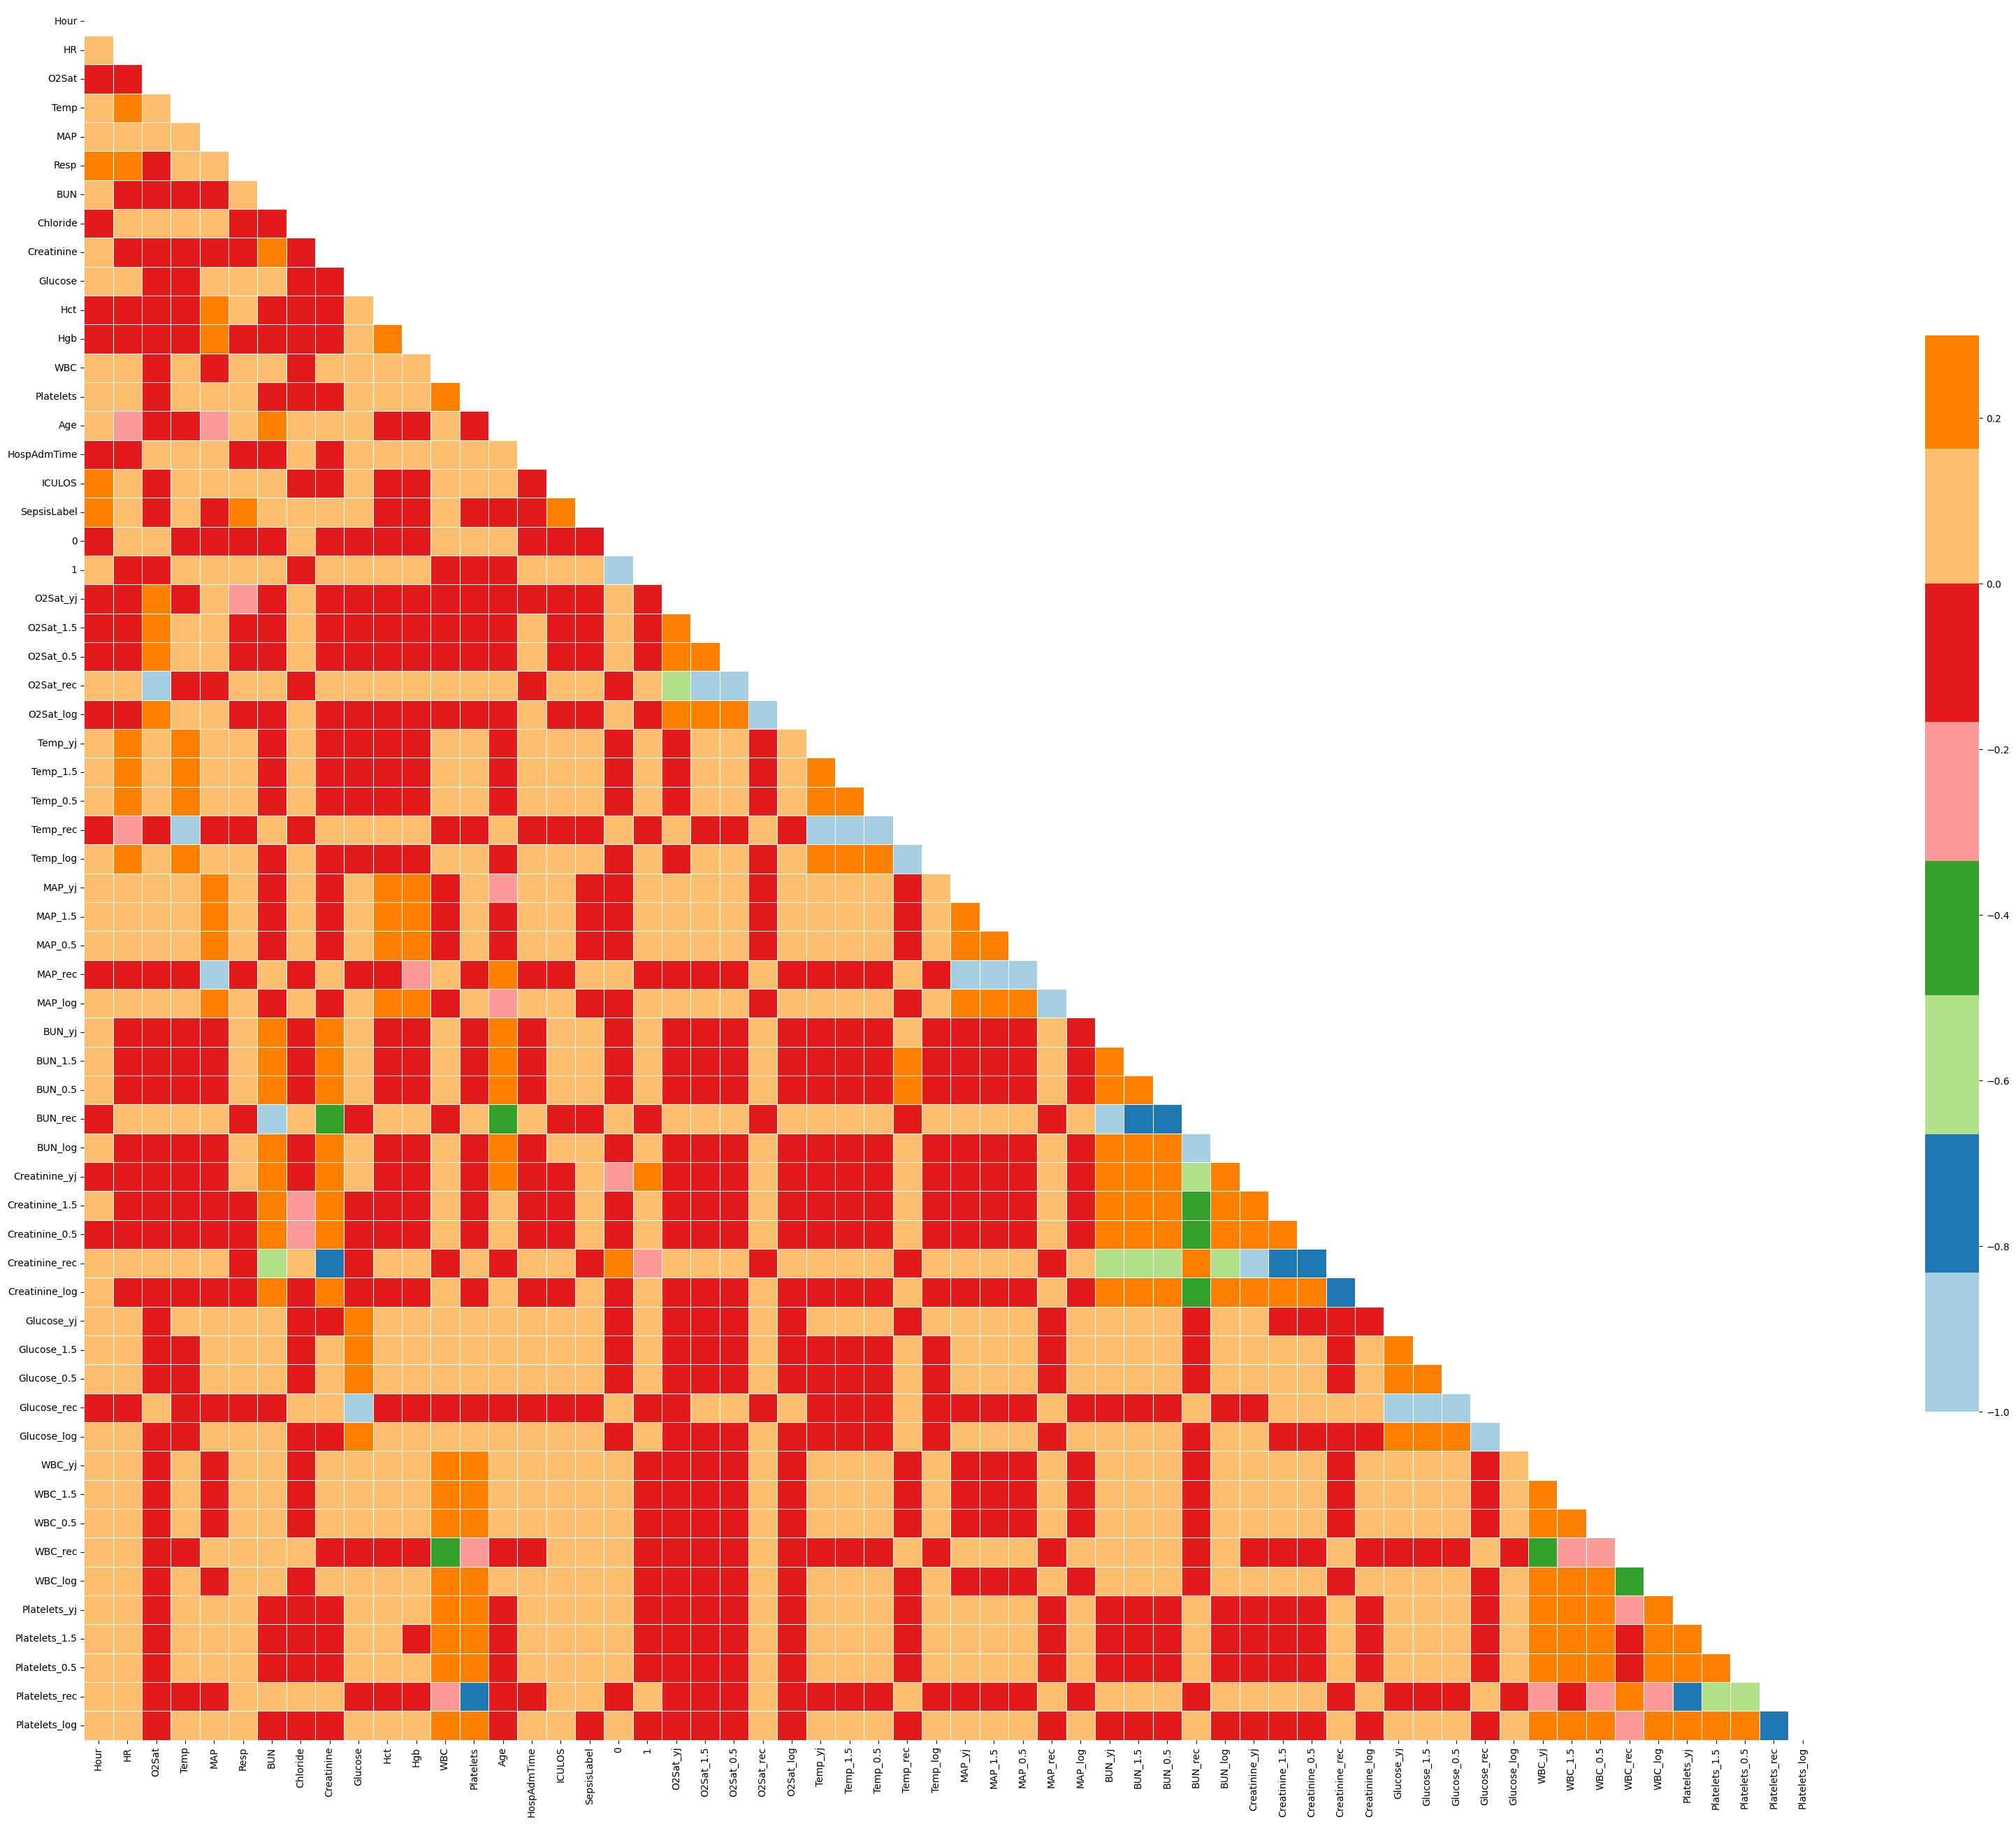

In [30]:
corr_matrix(df_train_impute)

In [31]:
# train test split for the imputed output
X = df_train_impute.drop('SepsisLabel', axis=1)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)

Accuracy: 0.9587831207065751
Precision: 0.9204437400950871
Recall: 0.9580996370834708
F1 Score: 0.938894277400582
AUC-ROC: 0.9586100791280546
Mean Absolute Error: 0.04121687929342493
Root Mean Squared Error: 0.2030194061990748


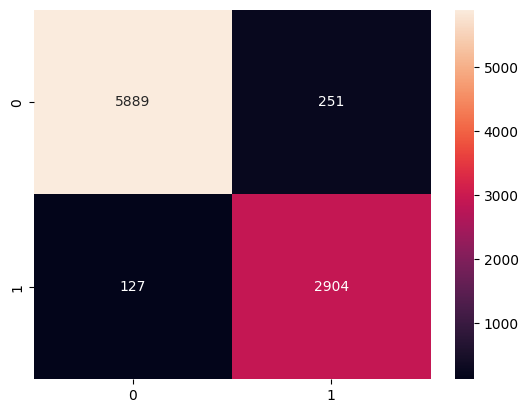

In [33]:
evaluate_model(y_test,rcf_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.9549667429942209
Precision: 0.9116352201257861
Recall: 0.9564500164962059
F1 Score: 0.9335050716470777
AUC-ROC: 0.9553422720917513
Mean Absolute Error: 0.045033257005779086
Root Mean Squared Error: 0.21221040739270797


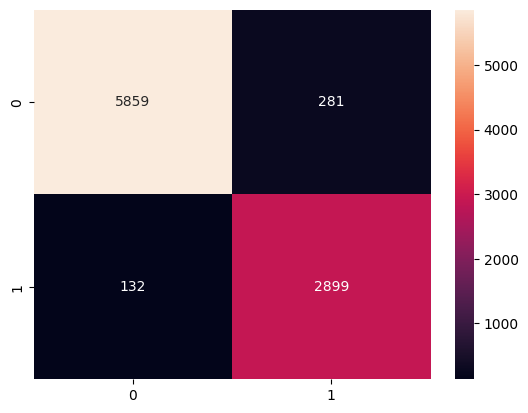

In [34]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier()

# Create a BaggingClassifier
bagging_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, random_state=0)
bagging_model.fit(X_train, y_train)
bagging_predictions = bagging_model.predict(X_test)
# Evaluate the model
evaluate_model(y_test, bagging_predictions)

Model: RandomForestClassifier
Accuracy: 0.9561661759895322
Precision: 0.9196261682242991
Recall: 0.9534883720930233
F1 Score: 0.9362511893434825
AUC-ROC: 0.955509618145277
Mean Absolute Error: 0.04383382401046778
Root Mean Squared Error: 0.20936528845648644


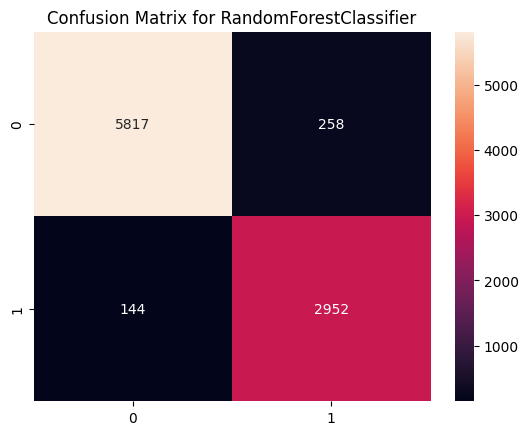

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model: BaggingClassifier
Accuracy: 0.9510413259186566
Precision: 0.9076070218663381
Recall: 0.9518733850129198
F1 Score: 0.9292133060066216
AUC-ROC: 0.9512453344817685
Mean Absolute Error: 0.04895867408134336
Root Mean Squared Error: 0.22126607078660607


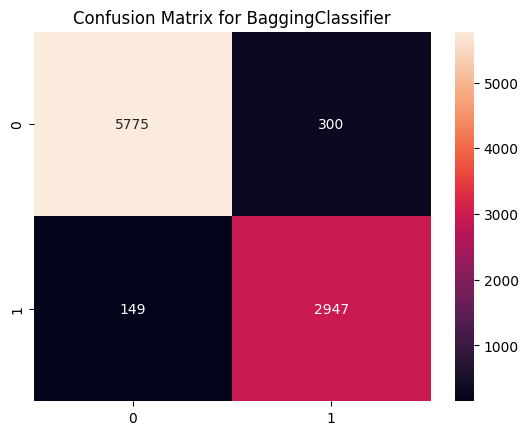

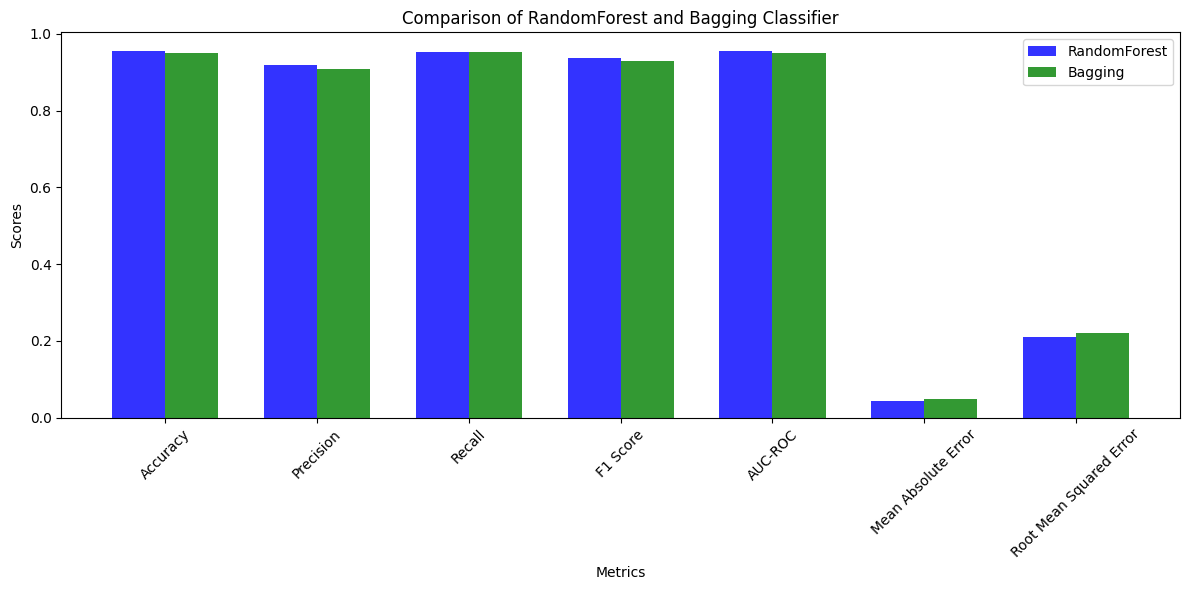

In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

# Load the dataset
combined = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset.csv')

# Split dataset based on Patient_ID length
rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

df_train = pd.read_csv('/content/data_part1.csv')
df_test = pd.read_csv('/content/data_part2.csv')

# Define correlation matrix function
def corr_matrix(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(40, 40))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Preprocess the training data
columns_drop = {'Unnamed: 0', 'SBP', 'DBP', 'EtCO2', 'BaseExcess', 'HCO3', 'pH', 'PaCO2', 'Alkalinephos', 'Calcium', 'Magnesium', 'Phosphate', 'Potassium', 'PTT', 'Fibrinogen', 'Unit1', 'Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)

# Imputation
df_train_impute = df_train_mod.copy()
grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

# Drop columns with too many null values and Patient_ID
null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2', 'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)

# One-hot encoding for gender
one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot).drop('Gender', axis=1)

# Gaussian transformation and normalization
columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets']
for col in columns_normalized:
    df_train_impute[col] = np.log(df_train_impute[col] + 1)

scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride', 'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride', 'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])

# Drop any remaining null values
df_train_impute = df_train_impute.dropna()

# Balance the dataset
majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_balanced = pd.concat([majority_class_subset, minority_class])

# Split into features and target
X = df_train_balanced.drop('SepsisLabel', axis=1)
y = df_train_balanced['SepsisLabel']

# Convert column names to strings
X.columns = X.columns.astype(str)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Evaluate model function
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC: {auc}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    return accuracy, precision, recall, f1, auc, mae, rmse

# RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=300, random_state=0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_metrics = evaluate_model(y_test, rf_predictions, "RandomForestClassifier")

# BaggingClassifier
base_estimator = DecisionTreeClassifier()
bagging_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, random_state=0)
bagging_model.fit(X_train, y_train)
bagging_predictions = bagging_model.predict(X_test)
bagging_metrics = evaluate_model(y_test, bagging_predictions, "BaggingClassifier")

# Graphical Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'Mean Absolute Error', 'Root Mean Squared Error']
rf_metrics_values = rf_metrics # include all metrics
bagging_metrics_values = bagging_metrics # include all metrics

x = np.arange(len(metrics)) # x should have the same number of elements as the metrics

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(x, rf_metrics_values, bar_width, alpha=opacity, color='b', label='RandomForest')
rects2 = plt.bar(x + bar_width, bagging_metrics_values, bar_width, alpha=opacity, color='g', label='Bagging')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of RandomForest and Bagging Classifier')
plt.xticks(x + bar_width / 2, metrics, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

